In [6]:
!which python

/Users/dingyi/miniconda3/envs/SSDR/bin/python


In [2]:
# conda list --explicit > SSDR_spec_file.txt
# conda remove --name SSDR --all

# conda create --name SSDR python=3.8
# conda install -n SSDR ipykernel
# python -m ipykernel install --user --name SSDR --display-name "Python (SSDR)"

# conda activate SSDR
# conda install --name SSDR --file SSDR_spec_file.txt


# !which python
# !conda list  # For conda-installed packages
# conda install conda-forge::scikit-learn
# conda install conda-forge::tensorflow
# conda install conda-forge::pandas
# conda install conda-forge::numpy==1.19
# conda install conda-forge::matplotlib
# conda install pytorch::pytorch


# rm -rf build
# git clean -xdf

# export PATH=~/miniconda3/envs/SSDR/bin:$PATH

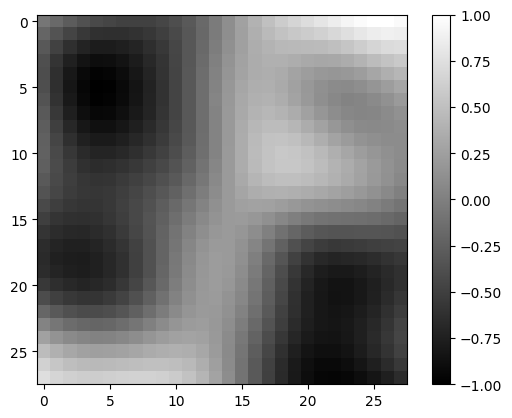

In [3]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Define image size (e.g., 28x28 for MNIST-like images)
image_size = 28
x = np.linspace(0, 1, image_size)
y = np.linspace(0, 1, image_size)
X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T  # Coordinates for each pixel

# Define the kernel for smoothness
length_scale = 0.2  # Adjust for desired smoothness
kernel = RBF(length_scale=length_scale)

# Sample from a Gaussian Process
gp = GaussianProcessRegressor(kernel=kernel)
intensity_samples = gp.sample_y(coords, n_samples=1, random_state=0).reshape(image_size, image_size)

# Normalize intensity to [0, 255] for a grayscale image
# intensity_samples = 255 * (intensity_samples - intensity_samples.min()) / (intensity_samples.max() - intensity_samples.min())
intensity_samples = (intensity_samples - intensity_samples.min()) / (intensity_samples.max() - intensity_samples.min())
intensity_samples = 2 * intensity_samples - 1
# Visualize the simulated image
import matplotlib.pyplot as plt
plt.imshow(intensity_samples, cmap="gray")
plt.colorbar()
plt.show()

In [4]:
### Start from here

import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import norm


In [5]:
N = [100, 500, 1000] # sample sizes: 100, 500, 1000
D = ['Poisson', 'Homo_Gamma', 'Hetero_Gaussian'] # true distribution

We consider the following generic semi-structured predictor $\eta_k$:

$$\eta_k = \beta_k + \alpha_{k,1} X_1 + \alpha_{k,2} X_2 + f_{k,1}(Z_1) + f_{k,2}(Z_2) + \text{d}(U),$$

where:
- $\tilde{X}_1, \tilde{X}_2 \sim \mathcal{N}(0, 1)$ are structured covariates for linear effects, and $\tilde{\alpha}_{1,1}, \tilde{\alpha}_{1,2}, \tilde{\alpha}_{2,1}$ and $\tilde{\alpha}_{2,2}$ are set to be 3, -1, -0.5 and 6 respectively. $X_1$ and $X_2$ are scaled from $\tilde{X}_1$ and $\tilde{X}_2$ into the range of $[0,1]$. Moreover, the linear effects for $\eta_k$ are scaled from $\sum_{i=1}^{2} \tilde{\alpha}_{k,i}\tilde{X}_i$ into $\sum_{i=1}^{2} \alpha_{k,i}X_i$ so that the scale of all effects is within the same range $[-1,1]$.

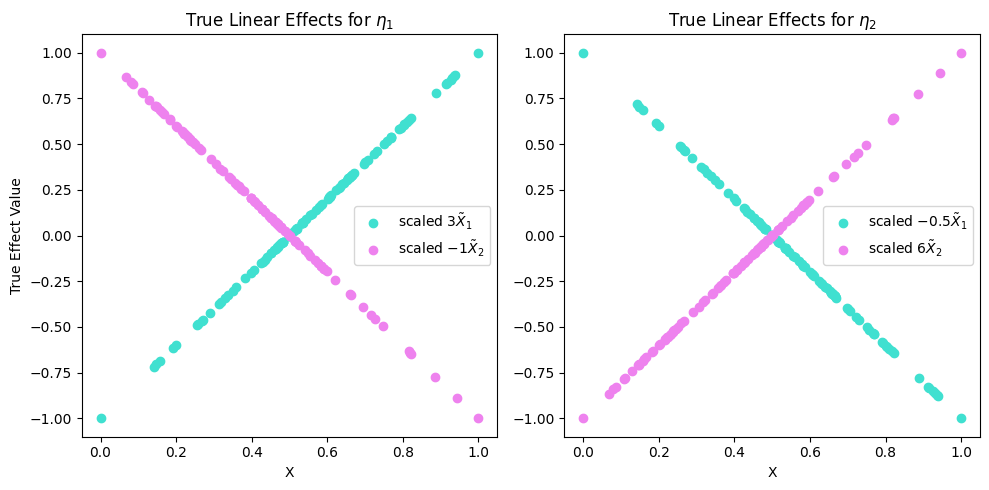

In [6]:

# 1. Structured Linear Effects
n = N[0]  # Adjust as needed
np.random.seed(42)
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)
X1_scaled = (X1-min(X1))/(max(X1)-min(X1))
X2_scaled = (X2-min(X2))/(max(X2)-min(X2))


alpha_11, alpha_12, alpha_21, alpha_22 = 3, -1, -0.5, 6
linear_effect_11 = alpha_11 * X1_scaled
linear_effect_12 = alpha_12 * X2_scaled
linear_effect_21 = alpha_21 * X1_scaled
linear_effect_22 = alpha_22 * X2_scaled
linear_effect_11_scaled = 2 * (linear_effect_11-min(linear_effect_11))/(max(linear_effect_11)-min(linear_effect_11)) - 1
linear_effect_12_scaled = 2 * (linear_effect_12-min(linear_effect_12))/(max(linear_effect_12)-min(linear_effect_12)) - 1
linear_effect_21_scaled = 2 * (linear_effect_21-min(linear_effect_21))/(max(linear_effect_21)-min(linear_effect_21)) - 1
linear_effect_22_scaled = 2 * (linear_effect_22-min(linear_effect_22))/(max(linear_effect_22)-min(linear_effect_22)) - 1

# Plot linear effect
# plt.figure(figsize=(10, 6))
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(X1_scaled, linear_effect_11_scaled, 'o', label='scaled $3 \\tilde{X}_1$', color="turquoise")
ax1.plot(X2_scaled, linear_effect_12_scaled, 'o', label='scaled $-1 \\tilde{X}_2$', color="violet")
ax1.set_title("True Linear Effects for $\\eta_1$")
ax1.set_xlabel("X")
ax1.set_ylabel("True Effect Value")
ax1.legend()

ax2.plot(X1_scaled, linear_effect_21_scaled, 'o', label='scaled $-0.5 \\tilde{X}_1$', color="turquoise")
ax2.plot(X2_scaled, linear_effect_22_scaled, 'o', label='scaled $6 \\tilde{X}_2$', color="violet")
ax2.set_title("True Linear Effects for $\\eta_2$")
ax2.set_xlabel("X")
# ax2.set_ylabel("True Effect Value")
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()


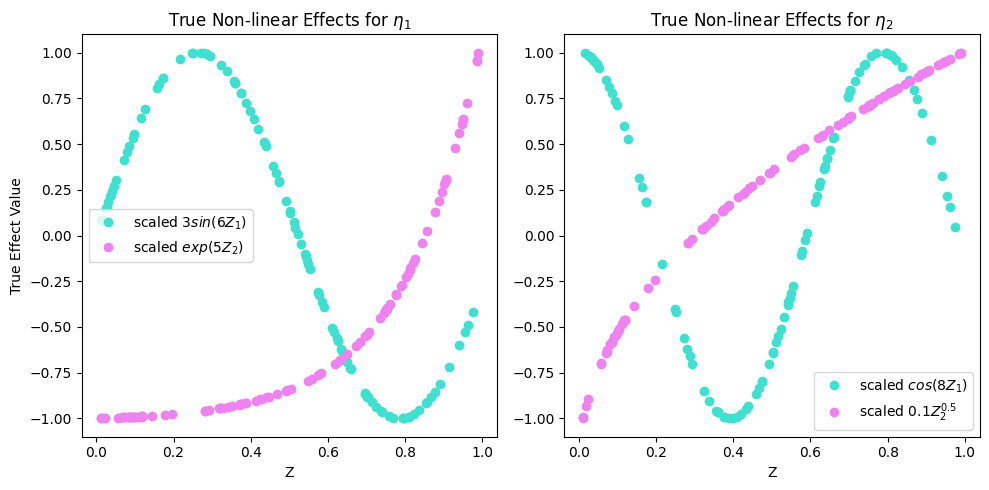

In [7]:

# 2. Structured Non-linear Effects
Z1 = np.random.uniform(0, 1, n)
Z2 = np.random.uniform(0, 1, n)

nonlinear_effect_11 = 3 * np.sin(6 * Z1)
nonlinear_effect_12 = np.exp(5 * Z2)
nonlinear_effect_21 = np.cos(8 * Z1)
nonlinear_effect_22 = 0.1*Z2**0.5
nonlinear_effect_11_scaled = 2 * (nonlinear_effect_11-min(nonlinear_effect_11))/(max(nonlinear_effect_11)-min(nonlinear_effect_11)) - 1
nonlinear_effect_12_scaled = 2 * (nonlinear_effect_12-min(nonlinear_effect_12))/(max(nonlinear_effect_12)-min(nonlinear_effect_12)) - 1
nonlinear_effect_21_scaled = 2 * (nonlinear_effect_21-min(nonlinear_effect_21))/(max(nonlinear_effect_21)-min(nonlinear_effect_21)) - 1
nonlinear_effect_22_scaled = 2 * (nonlinear_effect_22-min(nonlinear_effect_22))/(max(nonlinear_effect_22)-min(nonlinear_effect_22)) - 1

# Plot non-linear effects
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(Z1, nonlinear_effect_11_scaled, 'o', label='scaled $3 sin(6 Z_1)$', color="turquoise")
ax1.plot(Z2, nonlinear_effect_12_scaled, 'o', label='scaled $exp(5 Z_2)$', color="violet")
ax1.set_title("True Non-linear Effects for $\\eta_1$")
ax1.set_xlabel("Z")
ax1.set_ylabel("True Effect Value")
ax1.legend()

ax2.plot(Z1, nonlinear_effect_21_scaled, 'o', label='scaled $cos(8 Z_1)$', color="turquoise")
ax2.plot(Z2, nonlinear_effect_22_scaled, 'o', label='scaled $0.1 Z_2^{0.5}$', color="violet")
ax2.set_title("True Non-linear Effects for $\\eta_2$")
ax2.set_xlabel("Z")
# ax2.set_ylabel("True Effect Value")
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()


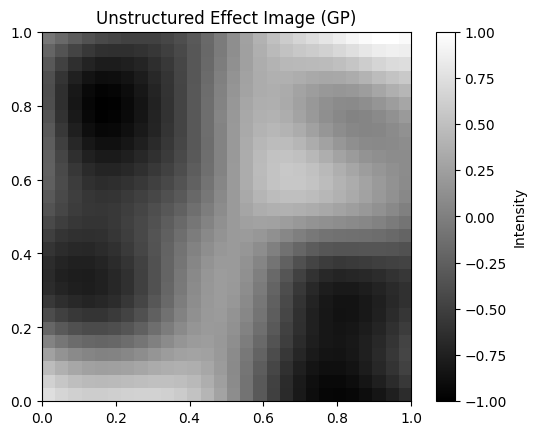

In [8]:

# 3. Unstructured Effect (Image using GP)
image_size = 28
x = np.linspace(0, 1, image_size)
y = np.linspace(0, 1, image_size)
X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T

# Define the GP kernel and create a GP
length_scale = 0.2
kernel = RBF(length_scale=length_scale)
gp = GaussianProcessRegressor(kernel=kernel)

# Sample intensity values from the GP
intensity_samples = gp.sample_y(coords, n_samples=1, random_state=0).reshape(image_size, image_size)

# Scale to [-1,1]
intensity_samples = 2 * (intensity_samples - intensity_samples.min()) / (intensity_samples.max() - intensity_samples.min()) - 1

# Plot unstructured effect (GP image)
plt.figure()
plt.imshow(intensity_samples, cmap="gray", extent=(0, 1, 0, 1))
plt.colorbar(label="Intensity")
plt.title("Unstructured Effect Image (GP)")
plt.show()


In [9]:
# import numpy as np
# import noise  # Install with `pip install noise`
# import matplotlib.pyplot as plt

# def generate_perlin_image(size=28, octaves=4, persistence=0.5, lacunarity=2.0):
#     image = np.zeros((size, size))
#     scale = 5.0  # Controls the "zoom" level of the noise

#     # Normalize coordinates to [0, 1]
#     for i in range(size):
#         for j in range(size):
#             x, y = i / (size - 1), j / (size - 1)  # Normalized to [0, 1]
#             image[i][j] = noise.pnoise2(x * scale, y * scale, octaves=octaves, persistence=persistence, lacunarity=lacunarity, repeatx=size, repeaty=size, base=42)
    
#     # Normalize the image values to [-1, 1] range
#     image = 2 * (image - np.min(image)) / (np.max(image) - np.min(image)) - 1
#     return image

# # Generate and display the image
# perlin_image = generate_perlin_image()
# plt.imshow(perlin_image, cmap='gray', extent=[0, 1, 0, 1])
# plt.colorbar()
# plt.title("Simulated Image Using Perlin Noise with Normalized Coordinates")
# plt.xlabel("Normalized X (0 to 1)")
# plt.ylabel("Normalized Y (0 to 1)")
# plt.show()

In [10]:

# 4. Coverage Rate Calculation Example (for linear effect alpha_1)
# Assuming alpha_hat and its CI for each replication are obtained through some estimation method

# Placeholder example data
R = 100  # Number of replications
true_alpha_1 = 3
alpha_hat_samples = np.random.normal(loc=true_alpha_1, scale=0.5, size=R)  # Simulated estimated alpha values
alpha_CI_low = alpha_hat_samples - 1.96 * 0.5  # 95% CI lower bound
alpha_CI_high = alpha_hat_samples + 1.96 * 0.5  # 95% CI upper bound

# Compute coverage rate
coverage_rate_alpha_1 = np.mean((true_alpha_1 >= alpha_CI_low) & (true_alpha_1 <= alpha_CI_high))
print(f"Coverage Rate for Linear Effect α₁: {coverage_rate_alpha_1:.2f}")

# Repeat similar coverage rate calculations for other effects based on their respective confidence intervals

Coverage Rate for Linear Effect α₁: 0.93


Parallel Simulation for Coverage Rate Computation

In [2]:
!pip install ..

Processing /hkfs/home/haicore/scc/pa6512/PySSDR
  Preparing metadata (setup.py) ... done
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)
Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 107.1 MB/s eta 0:00:00
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Created wheel for PySddr: filename=PySddr-0.11.dev0-py3-none-any.whl size=34911 sha256=f2ef3cd682c565bd52de7fb883e3348fbf0ff13db895e82d9e5aa1a3a32ff1da
  Stored in directory: /scratch/pip-ephem-wheel-cache-sos28qq_/wheels/89/08/40/4e93508f24eb93ffd988f08e8e9af6db57057e7baeb3f7bfbf
Successfully bu

In [7]:
!hostname # Verify the Host

Dingyis-MacBook-Pro.local


In [1]:
!nvidia-smi


Mon Dec 23 11:22:39 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:CA:00.0 Off |                   On |
| N/A   43C    P0             49W /  400W |      87MiB /  40960MiB |     N/A      Default |
|                                         |                        |              Enabled |
+-----------------------------------------+-----

In [15]:
!kill -9 658088

/bin/bash: line 0: kill: (658088) - No such process


In [16]:
!squeue -u $USER  # SLURM example # This will display your active jobs and the allocated nodes.


             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           1489148    normal jupyterh   pa6512  R    1:41:03      1 haicn1701


In [1]:
import psutil

# Get total physical/logical CPU cores
print(f"Logical CPU cores available: {psutil.cpu_count(logical=True)}")
print(f"Physical CPU cores available: {psutil.cpu_count(logical=False)}")

# Check current CPU usage per core
cpu_usage = psutil.cpu_percent(percpu=True)
print(f"CPU usage per core: {cpu_usage}")


Logical CPU cores available: 152
Physical CPU cores available: 76
CPU usage per core: [2.5, 1.0, 4.0, 1.2, 0.5, 0.9, 9.3, 0.1, 4.9, 0.1, 0.2, 0.2, 0.2, 0.0, 0.9, 0.4, 1.2, 0.0, 0.1, 0.0, 0.1, 0.1, 0.0, 0.0, 0.1, 0.1, 0.1, 0.3, 3.4, 0.8, 0.3, 0.0, 0.0, 0.1, 0.5, 0.7, 0.9, 0.7, 11.1, 0.3, 1.2, 0.3, 0.1, 1.7, 0.7, 1.1, 0.1, 0.0, 0.1, 0.2, 0.0, 0.0, 0.1, 0.0, 0.4, 0.0, 0.1, 1.3, 0.0, 0.0, 1.4, 0.1, 0.1, 0.1, 0.5, 0.0, 0.0, 0.1, 1.3, 0.3, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 10.8, 1.8, 0.2, 0.0, 0.2, 0.1, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 13.8, 0.0, 13.8, 0.0, 0.2, 0.5, 0.2, 0.1, 0.0, 0.2, 0.0, 0.7, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.7, 0.0, 4.5, 17.6, 0.0, 0.0, 0.0, 0.2, 0.1, 0.2, 0.1, 0.1, 0.0, 0.6, 0.2, 0.3, 0.4, 0.0, 0.8, 0.0, 0.0, 0.0, 0.0, 0.4, 0.2, 1.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.1, 0.0]


In [2]:
import multiprocessing as mp
import logging
from worker import f 

def f(x):
    return g(x)*x

def g(x):
    return x*x

if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO)

    # Use a smaller pool size for debugging or scale based on CPU cores
    with mp.Pool(4) as pool:  # Adjust the pool size if necessary
        results = pool.map(f, [1, 2, 3, 4])
        
        # Simulating 'scenarios' length to avoid KeyError
        scenarios = [1, 2, 3, 4]

        for i, result in enumerate(results):
            logging.info(f"Completed {i+1}/{len(scenarios)} datasets.")


INFO:root:Completed 1/4 datasets.
INFO:root:Completed 2/4 datasets.
INFO:root:Completed 3/4 datasets.
INFO:root:Completed 4/4 datasets.


In [27]:
import multiprocessing as mp
import logging


class Worker:
    def __init__(self, a):
        self.a = a

    @staticmethod
    def f(xy, a):
        x, y = xy
        return x * y + a  # Simple operation

if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO)
    a_value = 6
    
    with mp.Pool(4) as pool:  # 4 parallel processes
        results = pool.starmap(Worker.f, [((1, 1), a_value), ((2, 3), a_value), ((3, 5), a_value), ((4, 6), a_value)])
        for i, result in enumerate(results):
            logging.info(f"Completed task {i+1} | Result: {result}")


INFO:root:Completed task 1 | Result: 7
INFO:root:Completed task 2 | Result: 12
INFO:root:Completed task 3 | Result: 21
INFO:root:Completed task 4 | Result: 30


In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import tensorflow as tf

from tensorflow.keras import Input, Model
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten, ReLU
# import torch.optim as optim

from time import time
from scipy.stats import poisson, gamma, norm
import multiprocessing as mp
# from sddr import Sddr  # Assuming you have pyssdr installed and configured correctly
import logging
from datetime import datetime
# import torch
logging.basicConfig(level=logging.INFO)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2024-12-23 14:36:32.634531: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-23 14:36:32.649967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734960992.663434 2880848 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734960992.667554 2880848 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-23 14:36:32.685374: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import tensorflow as tf

from tensorflow.keras import Input, Model
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten, ReLU
# import torch.optim as optim

from time import time
from scipy.stats import poisson, gamma, norm
import multiprocessing as mp
# from sddr import Sddr  # Assuming you have pyssdr installed and configured correctly
import logging
from datetime import datetime
# import torch
logging.basicConfig(level=logging.INFO)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# ---------------------------
# Helper Functions
# ---------------------------

def scale_to_range(data, lower=-1, upper=1):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * (upper - lower) + lower

def build_dnn(input_dim, layer_sizes=[32, 16], activation="relu"):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(layer_sizes[0], activation=activation),
        Dense(layer_sizes[1], activation=activation),
        Dense(1, activation=None)
    ])
    return model

def generate_gp_image(grid_size=28, length_scale=0.2, random_state=None):
    np.random.seed(random_state)
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    X, Y = np.meshgrid(x, y)
    coords = np.vstack([X.ravel(), Y.ravel()]).T

    kernel = RBF(length_scale=length_scale)
    gp = GaussianProcessRegressor(kernel=kernel)
    intensity = gp.sample_y(coords, n_samples=1).reshape(grid_size, grid_size)
    return scale_to_range(intensity)

# ---------------------------
# Simulation Functions
# ---------------------------

def generate_linear_effects(n_samples, K, I, alpha, random_state=None):
    np.random.seed(random_state)
    X = np.random.normal(size=(n_samples, I))
    X_scaled = scale_to_range(X, 0, 1)
    linear_effects = np.zeros((n_samples, K))

    for k in range(1, K + 1):
        for i in range(I):
            linear_effects[:, k - 1] += alpha[k][i] * X_scaled[:, i]
    return X_scaled, scale_to_range(linear_effects)

def generate_nonlinear_effects(n_samples, K, J, beta, random_state=None):
    np.random.seed(random_state)
    Z = np.random.uniform(0, 1, size=(n_samples, J))
    nonlinear_effects = np.zeros((n_samples, K))

    for k in range(1, K + 1):
        for j in range(J):
            nonlinear_effects[:, k - 1] += beta[k][j](Z[:, j])
    return Z, scale_to_range(nonlinear_effects)

def generate_unstructured_effects(images, dnn_model, K):
    n_samples = len(images)
    unstructured_effects = np.zeros((n_samples, K))

    for k in range(K):
        unstructured_output = np.random.rand(n_samples)  # Mock prediction
        unstructured_effects[:, k] = scale_to_range(unstructured_output)
    return unstructured_effects

def combine_effects(X, Z, unstructured_effects, linear_effects, nonlinear_effects, SNR):
    K = linear_effects.shape[1]
    etas = np.zeros((X.shape[0], K))

    for k in range(K):
        etas[:, k] = linear_effects[:, k] + nonlinear_effects[:, k] + unstructured_effects[:, k]
        std_eta = np.std(etas[:, k])
        intercept = (std_eta * SNR + np.min(etas[:, k]) - np.max(etas[:, k]))
        etas[:, k] += intercept
    return etas

def simulate_response(etas, distribution="poisson", K=2):
    n_samples = etas.shape[0]

    if distribution == "poisson" and K == 1:
        mu = np.exp(etas[:, 0])
        return np.random.poisson(mu)
    elif distribution == "gamma" and K == 2:
        mu = np.exp(etas[:, 0])
        sigma = 1.0
        shape = (mu / sigma) ** 2
        scale = sigma ** 2 / mu
        return np.random.gamma(shape, scale, n_samples)
    elif distribution == "gaussian" and K == 2:
        mu = etas[:, 0]
        sigma = np.exp(etas[:, 1])
        return np.random.normal(mu, sigma, n_samples)
    else:
        raise ValueError(f"Unsupported distribution: {distribution}")

def save_results(scenario, rep, n_samples, X, Z, images, etas, responses, save_path):
    os.makedirs(save_path, exist_ok=True)
    scenario_index = '_'.join(map(str, scenario))
    np.save(f"{save_path}/X_{scenario_index}_rep{rep}.npy", X)
    np.save(f"{save_path}/Z_{scenario_index}_rep{rep}.npy", Z)
    np.save(f"{save_path}/images_{scenario_index}_rep{rep}.npy", images)
    np.save(f"{save_path}/etas_{scenario_index}_rep{rep}.npy", etas)
    np.save(f"{save_path}/responses_{scenario_index}_rep{rep}.npy", responses)
    logging.info(f"Saved dataset {scenario_index}_rep{rep} and responses.")

# ---------------------------
# Generate Task Function for Parallel Execution
# ---------------------------

def generate_task(task_index, scenario_index, rep, scenarios, alpha, beta, grid_size, save_path):
    scenario = scenarios[scenario_index]
    n_samples, distribution, K, SNR = scenario
    
    # Build the DNN model (mock)
    dnn_model = build_dnn(grid_size * grid_size)

    logging.info(f"Generating dataset: Scenario {scenario_index} | Replication {rep} | {scenario}")
    
    # Generate structured and unstructured effects
    X, linear_effects = generate_linear_effects(n_samples, K, 2, alpha, random_state=task_index)
    Z, nonlinear_effects = generate_nonlinear_effects(n_samples, K, 2, beta, random_state=task_index)
    images = np.array([generate_gp_image(grid_size, random_state=task_index * 5000 + i) for i in range(n_samples)])
    unstructured_effects = generate_unstructured_effects(images, dnn_model, K)
    logging.info(f"Generated X, Z, images and unstructured_effects: Scenario {scenario_index} | Replication {rep} | {scenario}")
    
    etas = combine_effects(X, Z, unstructured_effects, linear_effects, nonlinear_effects, SNR)
    logging.info(f"Generated etas: Scenario {scenario_index} | Replication {rep} | {scenario}")
    
    # Generate response based on distribution
    responses = simulate_response(etas, distribution, K)
    logging.info(f"Generated responses: Scenario {scenario_index} | Replication {rep} | {scenario}")
    
    # Save datasets and responses
    save_results(scenario, rep, n_samples, X, Z, images, etas, responses, save_path)

# ---------------------------
# Parallel Execution Function
# ---------------------------

def parallel_generate(scenarios, grid_size, alpha, beta, n_cores=4, n_rep=4, save_path=None):
    logging.info("Starting parallel dataset generation...")
    start_time = datetime.now()
    
    # Create (scenario_index, rep) combinations for parallel processing
    task_list = [(i, r) for i in range(len(scenarios)) for r in range(n_rep)]
    logging.info(f"number of task_list: {len(task_list)}.")
    logging.info(f"number of cores used: {n_cores}.")
    
    # Use pool.starmap to pass multiple arguments to the method
    with mp.Pool(n_cores) as pool:
        pool.starmap(generate_task, [(idx, i, r, scenarios, alpha, beta, grid_size, save_path) 
                                     for idx, (i, r) in enumerate(task_list)])
    
    end_time = datetime.now()
    logging.info(f"Parallel dataset generation completed in {end_time - start_time}.")

# ---------------------------
# Scenario Setup
# ---------------------------

scenarios = [
    (100, "poisson", 1, 2), (500, "poisson", 1, 2), (1000, "poisson", 1, 2),
    (100, "poisson", 1, 4), (500, "poisson", 1, 4), (1000, "poisson", 1, 4),
    (100, "gamma", 2, 2), (500, "gamma", 2, 2), (1000, "gamma", 2, 2), 
   (100, "gamma", 1, 4), (500, "gamma", 2, 4), (1000, "gamma", 2, 4), 
   (100, "gaussian", 1, 2), (500, "gaussian", 2, 2), (1000, "gaussian", 2, 2),
   (100, "gaussian", 1, 4), (500, "gaussian", 2, 4), (1000, "gaussian", 2, 4)
]

grid_size = 28

# Define coefficients
alpha = {1: [3, -1], 2: [-0.5, 6]}

# Define named functions for nonlinear effects
def nonlinear_effect_1_z1(z1):
    return scale_to_range(3 * np.sin(6 * z1))

def nonlinear_effect_1_z2(z2):
    return scale_to_range(np.exp(5 * z2))

def nonlinear_effect_2_z1(z1):
    return scale_to_range(np.cos(8 * z1))

def nonlinear_effect_2_z2(z2):
    return scale_to_range(0.1 * np.sqrt(z2))

# Example coefficients for nonlinear effects
beta = {
    1: [nonlinear_effect_1_z1, nonlinear_effect_1_z2],
    2: [nonlinear_effect_2_z1, nonlinear_effect_2_z2]
}

parallel_generate(scenarios, grid_size, alpha, beta, n_cores=152, n_rep=100)



INFO:root:Starting parallel dataset generation...
INFO:root:number of cores used: 152.


[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 60), (0, 61), (0, 62), (0, 63), (0, 64), (0, 65), (0, 66), (0, 67), (0, 68), (0, 69), (0, 70), (0, 71), (0, 72), (0, 73), (0, 74), (0, 75), (0, 76), (0, 77), (0, 78), (0, 79), (0, 80), (0, 81), (0, 82), (0, 83), (0, 84), (0, 85), (0, 86), (0, 87), (0, 88), (0, 89), (0, 90), (0, 91), (0, 92), (0, 93), (0, 94), (0, 95), (0, 96), (0, 97), (0, 98), (0, 99), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1

2024-12-23 11:54:39.576934: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-23 11:54:39.577823: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-23 11:54:39.586323: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: haicn1702.localdomain
2024-12-23 11:54:39.586349: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: haicn1702.localdomain
2024-12-23 11:54:39.586550: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.54.15
2024-12-23 11:54:39.586579: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version 

IndexError: list index out of range

In [ ]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import tensorflow as tf

from tensorflow.keras import Input, Model
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten, ReLU
# import torch.optim as optim

from time import time
from scipy.stats import poisson, gamma, norm
import multiprocessing as mp
# from sddr import Sddr  # Assuming you have pyssdr installed and configured correctly
import logging
from datetime import datetime
# import torch
logging.basicConfig(level=logging.INFO)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


# ---------------------------
# Helper Functions
# ---------------------------

def scale_to_range(data, lower=-1, upper=1):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * (upper - lower) + lower

def build_dnn(input_dim, layer_sizes=[32, 16], activation="relu"):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(layer_sizes[0], activation=activation),
        Dense(layer_sizes[1], activation=activation),
        Dense(1, activation=None)
    ])
    return model

def generate_gp_image(grid_size=28, length_scale=0.2, random_state=None):
    np.random.seed(random_state)
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    X, Y = np.meshgrid(x, y)
    coords = np.vstack([X.ravel(), Y.ravel()]).T

    kernel = RBF(length_scale=length_scale)
    gp = GaussianProcessRegressor(kernel=kernel)
    intensity = gp.sample_y(coords, n_samples=1).reshape(grid_size, grid_size)
    return scale_to_range(intensity)

# ---------------------------
# Simulation Functions
# ---------------------------

def generate_linear_effects(n_samples, K, I, alpha, random_state=None):
    np.random.seed(random_state)
    X = np.random.normal(size=(n_samples, I))
    X_scaled = scale_to_range(X, 0, 1)
    linear_effects = np.zeros((n_samples, K))

    for k in range(1, K + 1):
        for i in range(I):
            linear_effects[:, k - 1] += alpha[k][i] * X_scaled[:, i]
    return X_scaled, scale_to_range(linear_effects)

def generate_nonlinear_effects(n_samples, K, J, beta, random_state=None):
    np.random.seed(random_state)
    Z = np.random.uniform(0, 1, size=(n_samples, J))
    nonlinear_effects = np.zeros((n_samples, K))

    for k in range(1, K + 1):
        for j in range(J):
            nonlinear_effects[:, k - 1] += beta[k][j](Z[:, j])
    return Z, scale_to_range(nonlinear_effects)

def generate_unstructured_effects(images, dnn_model, K):
    n_samples = len(images)
    unstructured_effects = np.zeros((n_samples, K))

    for k in range(K):
        unstructured_output = np.random.rand(n_samples)  # Mock prediction
        unstructured_effects[:, k] = scale_to_range(unstructured_output)
    return unstructured_effects

def combine_effects(X, Z, unstructured_effects, linear_effects, nonlinear_effects, SNR):
    K = linear_effects.shape[1]
    etas = np.zeros((X.shape[0], K))

    for k in range(K):
        etas[:, k] = linear_effects[:, k] + nonlinear_effects[:, k] + unstructured_effects[:, k]
        std_eta = np.std(etas[:, k])
        intercept = (std_eta * SNR + np.min(etas[:, k]) - np.max(etas[:, k]))
        etas[:, k] += intercept
    return etas

def simulate_response(etas, distribution="poisson", K=2):
    n_samples = etas.shape[0]

    if distribution == "poisson" and K == 1:
        mu = np.exp(etas[:, 0])
        return np.random.poisson(mu)
    elif distribution == "gamma" and K == 2:
        mu = np.exp(etas[:, 0])
        sigma = 1.0
        shape = (mu / sigma) ** 2
        scale = sigma ** 2 / mu
        return np.random.gamma(shape, scale, n_samples)
    elif distribution == "gaussian" and K == 2:
        mu = etas[:, 0]
        sigma = np.exp(etas[:, 1])
        return np.random.normal(mu, sigma, n_samples)
    else:
        raise ValueError(f"Unsupported distribution: {distribution}")

def save_results(scenario, rep, n_samples, X, Z, images, etas, responses, save_path):
    os.makedirs(save_path, exist_ok=True)
    scenario_index = '_'.join(map(str, scenario))
    np.save(f"{save_path}/X_{scenario_index}_rep{rep}.npy", X)
    np.save(f"{save_path}/Z_{scenario_index}_rep{rep}.npy", Z)
    np.save(f"{save_path}/images_{scenario_index}_rep{rep}.npy", images)
    np.save(f"{save_path}/etas_{scenario_index}_rep{rep}.npy", etas)
    np.save(f"{save_path}/responses_{scenario_index}_rep{rep}.npy", responses)
    logging.info(f"Saved dataset {scenario_index}_rep{rep} and responses.")

# ---------------------------
# Generate Task Function for Parallel Execution
# ---------------------------

def generate_task(task_index, scenario_index, rep, scenarios, alpha, beta, grid_size, save_path):
    scenario = scenarios[scenario_index]
    n_samples, distribution, K, SNR = scenario
    
    # Build the DNN model (mock)
    dnn_model = build_dnn(grid_size * grid_size)

    logging.info(f"Generating dataset: Scenario {scenario_index} | Replication {rep} | {scenario}")
    
    # Generate structured and unstructured effects
    X, linear_effects = generate_linear_effects(n_samples, K, 2, alpha, random_state=task_index)
    Z, nonlinear_effects = generate_nonlinear_effects(n_samples, K, 2, beta, random_state=task_index)
    images = np.array([generate_gp_image(grid_size, random_state=task_index * 5000 + i) for i in range(n_samples)])
    unstructured_effects = generate_unstructured_effects(images, dnn_model, K)
    logging.info(f"Generated X, Z, images and unstructured_effects: Scenario {scenario_index} | Replication {rep} | {scenario}")
    
    etas = combine_effects(X, Z, unstructured_effects, linear_effects, nonlinear_effects, SNR)
    logging.info(f"Generated etas: Scenario {scenario_index} | Replication {rep} | {scenario}")
    
    # Generate response based on distribution
    responses = simulate_response(etas, distribution, K)
    logging.info(f"Generated responses: Scenario {scenario_index} | Replication {rep} | {scenario}")
    
    # Save datasets and responses
    save_results(scenario, rep, n_samples, X, Z, images, etas, responses, save_path)

# ---------------------------
# Parallel Execution Function
# ---------------------------

# def parallel_generate(scenarios, grid_size, alpha, beta, n_cores=None, n_rep=4, save_path="output/"):
#     logging.info("Starting parallel dataset generation...")
#     start_time = datetime.now()
    
#     # Create (scenario_index, rep) combinations for parallel processing
#     task_list = [(i, r) for i in range(len(scenarios)) for r in range(n_rep)]
#     print(task_list)
#     # Ensure n_cores is set if not provided
#     if n_cores is None:
#         n_cores = n_rep * len(scenarios)
#     logging.info(f"number of cores used: {n_cores}.")
    
#     # Use pool.starmap to pass multiple arguments to the method
#     with mp.Pool(n_cores) as pool:
#         pool.starmap(generate_task, [(task_index, idx, r, scenarios, alpha, beta, grid_size, save_path) 
#                                      for idx, (task_index, r) in enumerate(task_list)])
    
#     end_time = datetime.now()
#     logging.info(f"Parallel dataset generation completed in {end_time - start_time}.")

def parallel_generate(scenarios, grid_size, alpha, beta, n_cores=None, total_reps=100, reps_per_chunk=10, save_path="output/"):
    logging.info("Starting parallel dataset generation...")
    start_time = datetime.now()

    # Generate (scenario_index, rep) combinations
    task_list = []
    task_index = 0  # Initialize task index
    
    for scenario_index in range(len(scenarios)):
        for rep in range(total_reps):
            task_list.append((task_index, scenario_index, rep))
            task_index += 1  # Increment task index

    # Split task_list into chunks
    chunk_count = len(task_list) // reps_per_chunk  # Number of chunks to process in parallel
    chunked_task_list = [task_list[i:i + reps_per_chunk] for i in range(0, len(task_list), reps_per_chunk)]
    print(len(chunked_task_list))
    # Default n_cores is set if not provided
    if n_cores is None:
        n_cores = min(152, len(chunked_task_list))  # Limit cores to 4 or the number of chunks
    logging.info(f"Using {n_cores} cores for parallel processing.")
    
    # Process each chunk in parallel
    with mp.Pool(n_cores) as pool:
        for chunk in chunked_task_list:
            pool.starmap(generate_task, [(task_index, scenario_index, rep, scenarios, alpha, beta, grid_size, save_path) 
                                         for task_index, scenario_index, rep in chunk])
    
    end_time = datetime.now()
    logging.info(f"Parallel dataset generation completed in {end_time - start_time}.")


# ---------------------------
# Scenario Setup
# ---------------------------

scenarios = [
    (100, "poisson", 1, 2), (500, "poisson", 1, 2), (1000, "poisson", 1, 2),
    (100, "poisson", 1, 4), (500, "poisson", 1, 4), (1000, "poisson", 1, 4),
    (100, "gamma", 2, 2), (500, "gamma", 2, 2), (1000, "gamma", 2, 2), 
   (100, "gamma", 2, 4), (500, "gamma", 2, 4), (1000, "gamma", 2, 4), 
   (100, "gaussian", 1, 2), (500, "gaussian", 2, 2), (1000, "gaussian", 2, 2),
   (100, "gaussian", 1, 4), (500, "gaussian", 2, 4), (1000, "gaussian", 2, 4)
]

grid_size = 28

# Define coefficients
alpha = {1: [3, -1], 2: [-0.5, 6]}

# Define named functions for nonlinear effects
def nonlinear_effect_1_z1(z1):
    return scale_to_range(3 * np.sin(6 * z1))

def nonlinear_effect_1_z2(z2):
    return scale_to_range(np.exp(5 * z2))

def nonlinear_effect_2_z1(z1):
    return scale_to_range(np.cos(8 * z1))

def nonlinear_effect_2_z2(z2):
    return scale_to_range(0.1 * np.sqrt(z2))

# Example coefficients for nonlinear effects
beta = {
    1: [nonlinear_effect_1_z1, nonlinear_effect_1_z2],
    2: [nonlinear_effect_2_z1, nonlinear_effect_2_z2]
}

# parallel_generate(scenarios, grid_size, alpha, beta, n_rep=50)
parallel_generate(scenarios, grid_size=28, alpha=alpha, beta=beta, n_cores=152, total_reps=100, reps_per_chunk=8)



In [38]:

# ---------------------------
# Helper Functions
# ---------------------------

def scale_to_range(data, lower=-1, upper=1):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * (upper - lower) + lower

def build_dnn(input_dim, layer_sizes=[32, 16], activation="relu"):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(layer_sizes[0], activation=activation),
        Dense(layer_sizes[1], activation=activation),
        Dense(1, activation=None)
    ])
    return model

def generate_gp_image(grid_size=28, length_scale=0.2, random_state=None):
    np.random.seed(random_state)
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    X, Y = np.meshgrid(x, y)
    coords = np.vstack([X.ravel(), Y.ravel()]).T

    kernel = RBF(length_scale=length_scale)
    gp = GaussianProcessRegressor(kernel=kernel)
    intensity = gp.sample_y(coords, n_samples=1).reshape(grid_size, grid_size)
    return scale_to_range(intensity)

# ---------------------------
# Simulation Functions
# ---------------------------

def generate_linear_effects(n_samples, K, I, alpha, random_state=None):
    np.random.seed(random_state)
    X = np.random.normal(size=(n_samples, I))
    X_scaled = scale_to_range(X, 0, 1)
    linear_effects = np.zeros((n_samples, K))

    for k in range(1, K + 1):
        for i in range(I):
            linear_effects[:, k - 1] += alpha[k][i] * X_scaled[:, i]
    return X_scaled, scale_to_range(linear_effects)

def generate_nonlinear_effects(n_samples, K, J, beta, random_state=None):
    np.random.seed(random_state)
    Z = np.random.uniform(0, 1, size=(n_samples, J))
    nonlinear_effects = np.zeros((n_samples, K))

    for k in range(1, K + 1):
        for j in range(J):
            nonlinear_effects[:, k - 1] += beta[k][j](Z[:, j])
    return Z, scale_to_range(nonlinear_effects)

def generate_unstructured_effects(images, dnn_model, K):
    n_samples = len(images)
    unstructured_effects = np.zeros((n_samples, K))

    for k in range(K):
        unstructured_output = np.random.rand(n_samples)  # Mock prediction
        unstructured_effects[:, k] = scale_to_range(unstructured_output)
    return unstructured_effects

def combine_effects(X, Z, unstructured_effects, linear_effects, nonlinear_effects, SNR):
    K = linear_effects.shape[1]
    etas = np.zeros((X.shape[0], K))

    for k in range(K):
        etas[:, k] = linear_effects[:, k] + nonlinear_effects[:, k] + unstructured_effects[:, k]
        std_eta = np.std(etas[:, k])
        intercept = (std_eta * SNR + np.min(etas[:, k]) - np.max(etas[:, k]))
        etas[:, k] += intercept
    return etas

def simulate_response(etas, distribution="poisson", K=2):
    n_samples = etas.shape[0]

    if distribution == "poisson" and K == 1:
        mu = np.exp(etas[:, 0])
        return np.random.poisson(mu)
    elif distribution == "gamma" and K == 2:
        mu = np.exp(etas[:, 0])
        sigma = 1.0
        shape = (mu / sigma) ** 2
        scale = sigma ** 2 / mu
        return np.random.gamma(shape, scale, n_samples)
    elif distribution == "gaussian" and K == 2:
        mu = etas[:, 0]
        sigma = np.exp(etas[:, 1])
        return np.random.normal(mu, sigma, n_samples)
    else:
        raise ValueError(f"Unsupported distribution: {distribution}")

def save_results(scenario, rep, n_samples, X, Z, images, etas, responses, save_path):
    os.makedirs(save_path, exist_ok=True)
    scenario_index = '_'.join(map(str, scenario))
    np.save(f"{save_path}/X_{scenario_index}_rep{rep}.npy", X)
    np.save(f"{save_path}/Z_{scenario_index}_rep{rep}.npy", Z)
    np.save(f"{save_path}/images_{scenario_index}_rep{rep}.npy", images)
    np.save(f"{save_path}/etas_{scenario_index}_rep{rep}.npy", etas)
    np.save(f"{save_path}/responses_{scenario_index}_rep{rep}.npy", responses)
    logging.info(f"Saved dataset {scenario_index}_rep{rep} and responses.")

# ---------------------------
# Generate Task Function for Parallel Execution
# ---------------------------

def generate_task(task_index, scenario_index, rep, scenarios, alpha, beta, grid_size, save_path):
    scenario = scenarios[scenario_index]
    n_samples, distribution, K, SNR = scenario
    
    # Build the DNN model (mock)
    dnn_model = build_dnn(grid_size * grid_size)

    logging.info(f"Generating dataset: Scenario {scenario_index} | Replication {rep} | {scenario}")
    
    # Generate structured and unstructured effects
    X, linear_effects = generate_linear_effects(n_samples, K, 2, alpha, random_state=task_index)
    Z, nonlinear_effects = generate_nonlinear_effects(n_samples, K, 2, beta, random_state=task_index)
    images = np.array([generate_gp_image(grid_size, random_state=task_index * 5000 + i) for i in range(n_samples)])
    unstructured_effects = generate_unstructured_effects(images, dnn_model, K)
    logging.info(f"Generated X, Z, images and unstructured_effects: Scenario {scenario_index} | Replication {rep} | {scenario}")
    
    etas = combine_effects(X, Z, unstructured_effects, linear_effects, nonlinear_effects, SNR)
    logging.info(f"Generated etas: Scenario {scenario_index} | Replication {rep} | {scenario}")
    
    # Generate response based on distribution
    responses = simulate_response(etas, distribution, K)
    logging.info(f"Generated responses: Scenario {scenario_index} | Replication {rep} | {scenario}")
    
    # Save datasets and responses
    save_results(scenario, rep, n_samples, X, Z, images, etas, responses, save_path)

# ---------------------------
# Parallel Execution Function
# ---------------------------

def parallel_generate(scenarios, grid_size, alpha, beta, n_cores=None, n_rep=4, save_path="output/"):
    logging.info("Starting parallel dataset generation...")
    start_time = datetime.now()
    
    # Create (scenario_index, rep) combinations for parallel processing
    task_list = [(i, r) for i in range(len(scenarios)) for r in range(n_rep)]
    print(task_list)
    # Ensure n_cores is set if not provided
    # if n_cores is None:
    #     n_cores = n_rep * len(scenarios)
    logging.info(f"number of cores used: {n_cores}.")
    
    # Use pool.starmap to pass multiple arguments to the method
    with mp.Pool(n_cores) as pool:
        pool.starmap(generate_task, [(task_index, idx, r, scenarios, alpha, beta, grid_size, save_path) 
                                     for idx, (task_index, r) in enumerate(task_list)])
    
    end_time = datetime.now()
    logging.info(f"Parallel dataset generation completed in {end_time - start_time}.")

# ---------------------------
# Scenario Setup
# ---------------------------

scenarios = [
    (100, "poisson", 1, 2), (500, "poisson", 1, 2), (1000, "poisson", 1, 2),
    (100, "poisson", 1, 4), (500, "poisson", 1, 4), (1000, "poisson", 1, 4),
    (100, "gamma", 2, 2), (500, "gamma", 2, 2), (1000, "gamma", 2, 2), 
   (100, "gamma", 1, 4), (500, "gamma", 2, 4), (1000, "gamma", 2, 4), 
   (100, "gaussian", 1, 2), (500, "gaussian", 2, 2), (1000, "gaussian", 2, 2),
   (100, "gaussian", 1, 4), (500, "gaussian", 2, 4), (1000, "gaussian", 2, 4)
]

grid_size = 28

# Define coefficients
alpha = {1: [3, -1], 2: [-0.5, 6]}

# Define named functions for nonlinear effects
def nonlinear_effect_1_z1(z1):
    return scale_to_range(3 * np.sin(6 * z1))

def nonlinear_effect_1_z2(z2):
    return scale_to_range(np.exp(5 * z2))

def nonlinear_effect_2_z1(z1):
    return scale_to_range(np.cos(8 * z1))

def nonlinear_effect_2_z2(z2):
    return scale_to_range(0.1 * np.sqrt(z2))

# Example coefficients for nonlinear effects
beta = {
    1: [nonlinear_effect_1_z1, nonlinear_effect_1_z2],
    2: [nonlinear_effect_2_z1, nonlinear_effect_2_z2]
}

parallel_generate(scenarios, grid_size, alpha, beta, n_cores=152, n_rep=100)


INFO:root:Starting parallel dataset generation...
INFO:root:number of cores used: 6.


[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0)]


INFO:root:Generating dataset: Scenario 1 | Replication 0 | (500, 'poisson', 1, 2)
INFO:root:Generating dataset: Scenario 0 | Replication 0 | (100, 'poisson', 1, 2)
INFO:root:Generating dataset: Scenario 4 | Replication 0 | (500, 'gamma', 2, 2)
INFO:root:Generating dataset: Scenario 3 | Replication 0 | (100, 'gamma', 1, 2)
INFO:root:Generating dataset: Scenario 2 | Replication 0 | (1000, 'poisson', 1, 2)
INFO:root:Generating dataset: Scenario 5 | Replication 0 | (1000, 'gamma', 2, 2)
INFO:root:Generated X, Z, images and unstructured_effects: Scenario 3 | Replication 0 | (100, 'gamma', 1, 2)
INFO:root:Generated etas: Scenario 3 | Replication 0 | (100, 'gamma', 1, 2)
INFO:root:Generated X, Z, images and unstructured_effects: Scenario 0 | Replication 0 | (100, 'poisson', 1, 2)
INFO:root:Generated etas: Scenario 0 | Replication 0 | (100, 'poisson', 1, 2)
INFO:root:Generated responses: Scenario 0 | Replication 0 | (100, 'poisson', 1, 2)
INFO:root:Saved dataset 0_rep0 and responses.
INFO:root

ValueError: Unsupported distribution: gamma

In [18]:
# Ensure TensorFlow uses GPU
print(tf.config.list_physical_devices('GPU'))


print("Is CUDA available?", torch.cuda.is_available())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is CUDA available? True


In [10]:

def dummy_function(i):
    return i**2

# Parallel execution
start_parallel = time()
with mp.Pool(processes=4) as pool:  # Replace 4 with the number of allocated cores
    results = pool.map(dummy_function, range(1000000))
print("Parallel Execution Time:", time() - start_parallel)

# Sequential execution
start_sequential = time()
results_seq = [dummy_function(i) for i in range(1000000)]
print("Sequential Execution Time:", time() - start_sequential)

# meaning that the parallel execution is even much slower

Parallel Execution Time: 0.4867572784423828
Sequential Execution Time: 0.2705116271972656


In [20]:
import os
print("SLURM_NODELIST:", os.getenv("SLURM_NODELIST"))
print("SLURM_CPUS_ON_NODE:", os.getenv("SLURM_CPUS_ON_NODE"))
print("SLURM_JOB_CPUS_PER_NODE:", os.getenv("SLURM_JOB_CPUS_PER_NODE"))


SLURM_NODELIST: haicn1701
SLURM_CPUS_ON_NODE: 2
SLURM_JOB_CPUS_PER_NODE: 2


In [21]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [26]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())

CUDA available: True
Current device: 0


In [25]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [7]:
import multiprocessing as mp

mp.set_start_method("spawn", force=True)

In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import tensorflow as tf

from tensorflow.keras import Input, Model
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten, ReLU
# import torch.optim as optim

from time import time
from scipy.stats import poisson, gamma, norm
import multiprocessing as mp
# from sddr import Sddr  # Assuming you have pyssdr installed and configured correctly
import logging
from datetime import datetime
# import torch

In [8]:
logging.basicConfig(level=logging.INFO)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [10]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


2024-12-22 09:16:41.091932: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-22 09:16:41.091974: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: haicn1701.localdomain
2024-12-22 09:16:41.091982: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: haicn1701.localdomain
2024-12-22 09:16:41.092083: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.54.15
2024-12-22 09:16:41.092103: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 550.54.15
2024-12-22 09:16:41.092107: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 550.54.15


In [11]:
with tf.device('/CPU:0'):
    # Any TensorFlow operations here will run on CPU
    print(tf.reduce_sum(tf.random.normal([1000, 1000])))


tf.Tensor(-15.288513, shape=(), dtype=float32)


In [23]:

# ---------------------------
# Helper Functions
# ---------------------------

def scale_to_range(data, lower=-1, upper=1):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * (upper - lower) + lower

def build_dnn(input_dim, layer_sizes=[32, 16], activation="relu"):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(layer_sizes[0], activation=activation),
        Dense(layer_sizes[1], activation=activation),
        Dense(1, activation=None)
    ])
    return model

def generate_gp_image(grid_size=28, length_scale=0.2, random_state=None):
    np.random.seed(random_state)
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    X, Y = np.meshgrid(x, y)
    coords = np.vstack([X.ravel(), Y.ravel()]).T

    kernel = RBF(length_scale=length_scale)
    gp = GaussianProcessRegressor(kernel=kernel)
    intensity = gp.sample_y(coords, n_samples=1).reshape(grid_size, grid_size)
    return scale_to_range(intensity)

# ---------------------------
# Simulation Class
# ---------------------------

class Simulation:
    def __init__(self, scenarios, grid_size=28, alpha=None, beta=None, save_path="output/"):
        self.scenarios = scenarios  # List of scenario configurations
        self.grid_size = grid_size
        self.alpha = alpha
        self.beta = beta
        self.dnn_model = build_dnn(grid_size * grid_size)
        self.dnn_model.save("dnn_model.keras")
        self.save_path = save_path
        os.makedirs(self.save_path, exist_ok=True)
        logging.info(f"Simulation initialized with {len(scenarios)} scenarios.")

    def generate(self, args):
        """
        Generate datasets and responses for a given index across all scenarios.
        """
        scenario_index, rep = args
        scenario = self.scenarios[scenario_index] 
        n_samples, distribution, K, SNR = scenario

        logging.info(f"Generating dataset: Scenario {scenario_index} | Replication {rep} | {scenario}")
        
        # Load the DNN model for each process
        self.dnn_model.load_weights("dnn_model.keras")

        # Generate structured and unstructured effects
        X, linear_effects = self.generate_linear_effects(n_samples, K, 2, random_state=rep)
        Z, nonlinear_effects = self.generate_nonlinear_effects(n_samples, K, 2, random_state=rep)
        images = np.array([generate_gp_image(self.grid_size, random_state=rep + i) for i in range(n_samples)])
        unstructured_effects = self.generate_unstructured_effects(images, dnn_model, K)
        logging.info(f"Generated X, Z, images and unstructured_effects: Scenario {scenario_index} | Replication {rep} | {scenario}")
        
        etas = self.combine_effects(X, Z, unstructured_effects, linear_effects, nonlinear_effects, SNR)
        logging.info(f"Generated etas: Scenario {scenario_index} | Replication {rep} | {scenario}")
        
        # Generate response based on distribution
        responses = self.simulate_response(etas, distribution, K)
        logging.info(f"Generated responses: Scenario {scenario_index} | Replication {rep} | {scenario}")
        
        # Save datasets and responses
        self.save_results(scenario_index, rep, n_samples, X, Z, images, etas, responses)
        
        # return etas, responses

    def generate_linear_effects(self, n_samples, K, I, random_state):
        np.random.seed(random_state)
        X = np.random.normal(size=(n_samples, I))
        X_scaled = scale_to_range(X, 0, 1)
        linear_effects = np.zeros((n_samples, K))

        for k in range(1, K + 1):
            for i in range(I):
                linear_effects[:, k - 1] += self.alpha[k][i] * X_scaled[:, i]
        return X_scaled, scale_to_range(linear_effects)

    def generate_nonlinear_effects(self, n_samples, K, J, random_state):
        np.random.seed(random_state)
        Z = np.random.uniform(0, 1, size=(n_samples, J))
        nonlinear_effects = np.zeros((n_samples, K))

        for k in range(1, K + 1):
            for j in range(J):
                nonlinear_effects[:, k - 1] += self.beta[k][j](Z[:, j])
        return Z, scale_to_range(nonlinear_effects)

    def generate_unstructured_effects(self, images, dnn_model, K):
        n_samples = len(images)
        unstructured_effects = np.zeros((n_samples, K))

        for k in range(K):
            unstructured_output = dnn_model.predict(images.reshape(n_samples, -1)).flatten()
            unstructured_effects[:, k] = scale_to_range(unstructured_output)
        return unstructured_effects

    def combine_effects(self, X, Z, unstructured_effects, linear_effects, nonlinear_effects, SNR):
        K = linear_effects.shape[1]
        etas = np.zeros((X.shape[0], K))

        for k in range(K):
            etas[:, k] = linear_effects[:, k] + nonlinear_effects[:, k] + unstructured_effects[:, k]
            std_eta = np.std(etas[:, k])
            intercept = (std_eta * SNR + np.min(etas[:, k]) - np.max(etas[:, k]))
            etas[:, k] += intercept
        return etas
    
    def simulate_response(self, etas, distribution="poisson", K=2):
        n_samples = etas.shape[0]

        if distribution == "poisson" and K == 1:
            mu = np.exp(etas[:, 0])
            return np.random.poisson(mu)
        elif distribution == "gamma" and K == 2:
            mu = np.exp(etas[:, 0])
            sigma = 1.0
            shape = (mu / sigma) ** 2
            scale = sigma ** 2 / mu
            return np.random.gamma(shape, scale, n_samples)
        elif distribution == "gaussian" and K == 2:
            mu = etas[:, 0]
            sigma = np.exp(etas[:, 1])
            return np.random.normal(mu, sigma, n_samples)
        else:
            raise ValueError(f"Unsupported distribution: {distribution}")

    def save_results(self, scenario_index, rep, n_samples, X, Z, images, etas, responses):
        np.save(f"{self.save_path}/X_{scenario_index}_rep{rep}.npy", X)
        np.save(f"{self.save_path}/Z_{scenario_index}_rep{rep}.npy", Z)
        np.save(f"{self.save_path}/images_{scenario_index}_rep{rep}.npy", images)
        np.save(f"{self.save_path}/etas_{scenario_index}_rep{rep}.npy", etas)
        np.save(f"{self.save_path}/responses_{scenario_index}_rep{rep}.npy", responses)
        logging.info(f"Saved dataset {scenario_index}_rep{rep} and responses.")

# ---------------------------
# Parallel Execution
# ---------------------------

def parallel_generate(scenarios, grid_size, alpha, beta, n_cores=None, n_rep=4):
    logging.info("Starting parallel dataset generation...")
    start_time = datetime.now()
    sim = Simulation(scenarios, grid_size, alpha, beta)
    # Create (scenario_index, rep) combinations for parallel processing
    task_list = [(i, r) for i in range(len(scenarios)) for r in range(n_rep)]
    print(task_list)
    if n_cores==None:
        n_cores = n_rep * len(scenarios)
    with mp.Pool(n_cores) as pool:
        pool.map(sim.generate, task_list)
    end_time = datetime.now()
    logging.info(f"Parallel dataset generation completed in {end_time - start_time}.")

# ---------------------------
# Scenario Setup
# ---------------------------

scenarios = [
    (100, "poisson", 1, 2), (500, "poisson", 1, 2), (1000, "poisson", 1, 2),
    (100, "poisson", 1, 4), (500, "poisson", 1, 4), (1000, "poisson", 1, 4),
    (100, "gamma", 1, 2), (500, "gamma", 2, 2), (1000, "gamma", 2, 2), 
    (100, "gamma", 1, 4), (500, "gamma", 2, 4), (1000, "gamma", 2, 4), 
    (100, "gaussian", 1, 2), (500, "gaussian", 2, 2), (1000, "gaussian", 2, 2),
    (100, "gaussian", 1, 4), (500, "gaussian", 2, 4), (1000, "gaussian", 2, 4)
]

grid_size = 28

# Define coefficients
alpha = {1: [3, -1], 2: [-0.5, 6]}

# Define named functions for nonlinear effects
def nonlinear_effect_1_z1(z1):
    return scale_to_range(3 * np.sin(6 * z1))

def nonlinear_effect_1_z2(z2):
    return scale_to_range(np.exp(5 * z2))

def nonlinear_effect_2_z1(z1):
    return scale_to_range(np.cos(8 * z1))

def nonlinear_effect_2_z2(z2):
    return scale_to_range(0.1 * np.sqrt(z2))

# Example coefficients for nonlinear effects
beta = {
    1: [nonlinear_effect_1_z1, nonlinear_effect_1_z2],
    2: [nonlinear_effect_2_z1, nonlinear_effect_2_z2]
}

parallel_generate(scenarios, grid_size, alpha, beta, n_cores=4)

INFO:root:Starting parallel dataset generation...
INFO:root:Simulation initialized with 18 scenarios.


[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3), (4, 0), (4, 1), (4, 2), (4, 3), (5, 0), (5, 1), (5, 2), (5, 3), (6, 0), (6, 1), (6, 2), (6, 3), (7, 0), (7, 1), (7, 2), (7, 3), (8, 0), (8, 1), (8, 2), (8, 3), (9, 0), (9, 1), (9, 2), (9, 3), (10, 0), (10, 1), (10, 2), (10, 3), (11, 0), (11, 1), (11, 2), (11, 3), (12, 0), (12, 1), (12, 2), (12, 3), (13, 0), (13, 1), (13, 2), (13, 3), (14, 0), (14, 1), (14, 2), (14, 3), (15, 0), (15, 1), (15, 2), (15, 3), (16, 0), (16, 1), (16, 2), (16, 3), (17, 0), (17, 1), (17, 2), (17, 3)]


KeyboardInterrupt: 

In [19]:


# ---------------------------
# Helper Functions
# ---------------------------

def scale_to_range(data, lower=-1, upper=1):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * (upper - lower) + lower

def build_dnn(input_dim, layer_sizes=[32, 16], activation="relu"):
    logging.info("Building DNN model...")
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(layer_sizes[0], activation=activation))
    model.add(Dense(layer_sizes[1], activation=activation))
    model.add(Dense(1, activation=None))
    logging.info("DNN model built.")
    return model

def generate_linear_effects(n_samples, K=2, I=2, alpha=None, random_state=42):
    np.random.seed(random_state)
    X = np.random.normal(size=(n_samples, I))
    X_scaled = scale_to_range(X, 0, 1)
    if alpha is None:
        raise ValueError("Alpha coefficients must be provided.")

    linear_effects = np.zeros((n_samples, K))
    for k in range(1, K + 1):
        for i in range(I):
            linear_effects[:, k - 1] += alpha[k][i] * X_scaled[:, i]
    return X_scaled, scale_to_range(linear_effects)

def generate_nonlinear_effects(n_samples, K=2, J=2, beta=None, random_state=42):
    np.random.seed(random_state)
    Z = np.random.uniform(0, 1, size=(n_samples, J))
    if beta is None:
        raise ValueError("Beta coefficients must be provided.")
    
    nonlinear_effects = np.zeros((n_samples, K))
    for k in range(1, K + 1):
        for j in range(J):
            nonlinear_effects[:, k - 1] += beta[k][j](Z[:, j])
    return Z, scale_to_range(nonlinear_effects)

def generate_gp_image(grid_size=28, length_scale=0.2, random_state=None):
    np.random.seed(random_state)
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    X, Y = np.meshgrid(x, y)
    coords = np.vstack([X.ravel(), Y.ravel()]).T

    kernel = RBF(length_scale=length_scale)
    gp = GaussianProcessRegressor(kernel=kernel)
    intensity = gp.sample_y(coords, n_samples=1).reshape(grid_size, grid_size)
    return scale_to_range(intensity)

def generate_unstructured_effects(images, dnn_model, K=2):
    n_samples = len(images)
    unstructured_effects = np.zeros((n_samples, K))
    for k in range(K):
        unstructured_output = dnn_model.predict(images.reshape(n_samples, -1)).flatten()
        unstructured_effects[:, k] = scale_to_range(unstructured_output)
    return unstructured_effects

# ---------------------------
# Dataset Generation
# ---------------------------

def generate_dataset(n_samples, K=2, I=2, J=2, SNR=None, grid_size=28, alpha=None, beta=None, dnn_model=None, random_state=42):
    """
    Generate structured and unstructured data for SSDR.
    """
    logging.info(f"Generating dataset with {n_samples} samples...")
    # Structured linear effects
    X, linear_effects = generate_linear_effects(n_samples, K, I, alpha, random_state)

    # Structured nonlinear effects
    Z, nonlinear_effects = generate_nonlinear_effects(n_samples, K, J, beta, random_state)

    # Unstructured effects (images using GP)
    images = np.array([generate_gp_image(grid_size, random_state=random_state + i) for i in range(n_samples)])

    # Unstructured effects via DNN
    if dnn_model is None:
        raise ValueError("A pre-trained DNN model must be provided for generating unstructured effects.")
    unstructured_effects = generate_unstructured_effects(images, dnn_model, K)

    # Combine effects into predictors (etas)
    
    intercept = np.zeros(K)
    etas = np.zeros((n_samples, K))
    for k in range(K):
        etas[:, k] = linear_effects[:, k] + nonlinear_effects[:, k] + unstructured_effects[:, k]
        
        # Adjust intercept to ensure SNR
        std_eta = np.std(etas[:, k])
        intercept[k] = (std_eta * SNR + np.min(etas[:, k]) - np.max(etas[:, k]))
        etas[:, k] += intercept
        
    logging.info(f"Dataset generated: {n_samples} samples for {distribution}.")
    return intercept, X, Z, images, etas

# Simulate response
def simulate_response(etas, distribution="poisson", K=2):
    """
    Simulate responses based on predictors (etas).
    """
    n_samples = etas.shape[0]
    if distribution == "poisson" and K == 1:
        mu = np.exp(etas[:, 0])
        return np.random.poisson(mu)
    elif distribution == "gamma" and K == 2:
        mu = np.exp(etas[:, 0])
        sigma = 1.0
        shape = (mu / sigma) ** 2
        scale = sigma ** 2 / mu
        return np.random.gamma(shape, scale, n_samples)
    elif distribution == "gaussian" and K == 2:
        mu = etas[:, 0]
        sigma = np.exp(etas[:, 1])
        return np.random.normal(mu, sigma, n_samples)
    else:
        raise ValueError("Unsupported distribution or incorrect K value.")
        
# ---------------------------
# Parallel Processing
# ---------------------------

def generate_single_dataset(args):
    """
    Wrapper for generating a single dataset and immediately saving it.
    Args:
        args: Tuple containing (n_samples, K, I, J, grid_size, alpha, beta, dnn_model, random_state).
    """
    n_samples, K, I, J, grid_size, alpha, beta, dnn_model, random_state = args
    # Initialize the DNN model within the process
    dnn_model = build_dnn(grid_size * grid_size)
    dnn_model.load_weights("dnn_model.keras")
    
    # Generate the dataset
    intercept, X, Z, images, etas = generate_dataset(
        n_samples=n_samples,
        K=K,
        I=I,
        J=J,
        SNR=SNR,
        grid_size=grid_size,
        alpha=alpha,
        beta=beta,
        dnn_model=dnn_model,
        random_state=random_state
    )
    
    # Save the generated data immediately
    save_separate_effects(intercepts, X, Z, random_state)
    save_images(images, random_state)
    save_eta_dataframes(etas, K, random_state)
    
    return intercept, X, Z, images, etas  # Optional, only if needed later

def parallel_generate_datasets(
    scenarios, dnn_model, n_cores=None, grid_size=28, alpha=None, beta=None
):
    """
    Generate multiple datasets in parallel.
    Args:
        scenarios: List of tuples, each specifying (n_samples, K, I, J, random_state).
        dnn_model: Pre-trained DNN model for unstructured effects.
        n_cores: Number of parallel processes to use.
        grid_size: Size of the image grid for unstructured effects.
        alpha: Coefficients for linear effects.
        beta: Coefficients for nonlinear effects.
    Returns:
        List of generated datasets.
    """
    logging.info("Starting parallel dataset generation...")
    start_time = datetime.now()
    
    # Dynamically set n_cores to the number of CPU cores available
    if n_cores is None:
        n_cores = mp.cpu_count()  # Use all available cores
    
    logging.info(f"Using {n_cores} cores for parallel processing.")

    args_list = [
        (n_samples, K, I, J, grid_size, alpha, beta, dnn_model, random_state)
        for n_samples, K, I, J, random_state in scenarios
    ]

    with mp.Pool(n_cores) as pool:
        results = pool.map(generate_single_dataset, args_list)
        for i, result in enumerate(results, 1):
            logging.info(f"Completed dataset {i}/{len(scenarios)}...")

    end_time = datetime.now()
    logging.info(f"Parallel dataset generation completed in {end_time - start_time}.")
    return results


# # Create a directory to save images
# image_dir = 'generated_images'
# os.makedirs(image_dir, exist_ok=True)

def save_separate_effects(intercepts, X, Z, dataset_index):
    # Create a DataFrame for separate effects
    df = pd.DataFrame({
        'intercepts': intercepts,
        'X': list(X),
        'Z': list(Z)
    })
    df.to_csv(f"separate_effects_{dataset_index}.csv", index=False)

def save_images(images, dataset_index):
    # Save images in the designated folder
    for i, img in enumerate(images):
        plt.imshow(img, cmap='viridis')
        plt.axis('off')  # Hide axes
        plt.savefig(f"{image_dir}/image_{dataset_index}_{i}.png", bbox_inches='tight', pad_inches=0)

def save_eta_dataframes(etas, K, dataset_index):
    # Save eta values as DataFrames
    for k in range(K):
        eta_df = pd.DataFrame(etas[:, k], columns=[f"eta_{k+1}"])
        eta_df.to_csv(f"eta_{dataset_index}_k{k+1}.csv", index=False)

def store_results(datasets):
    for idx, (intercepts, X, Z, images, etas) in enumerate(datasets):
        # Save separate effects
        save_separate_effects(intercepts, X, Z, idx)

        # Save images
        save_images(images, idx)

        # Save eta values
        save_eta_dataframes(etas, K=2, dataset_index=idx)



# ---------------------------
# Simulation Setup
# ---------------------------

scenarios = [
    (100, "poisson", 2, 2), (500, "poisson", 2, 2), (1000, "poisson", 2, 2),
    (100, "gamma", 2, 4)
]

# Define coefficients
alpha = {1: [3, -1], 2: [-0.5, 6]}

# Define named functions for nonlinear effects
def nonlinear_effect_1_z1(z1):
    return scale_to_range(3 * np.sin(6 * z1))

def nonlinear_effect_1_z2(z2):
    return scale_to_range(np.exp(5 * z2))

def nonlinear_effect_2_z1(z1):
    return scale_to_range(np.cos(8 * z1))

def nonlinear_effect_2_z2(z2):
    return scale_to_range(0.1 * np.sqrt(z2))

# Example coefficients for nonlinear effects
beta = {
    1: [nonlinear_effect_1_z1, nonlinear_effect_1_z2],
    2: [nonlinear_effect_2_z1, nonlinear_effect_2_z2]
}
# Pre-trained DNN for unstructured effects
grid_size = 28
dnn_model = build_dnn(grid_size * grid_size)
dnn_model.save("dnn_model.keras")
# Optionally train/load weights for DNN model
# dnn_model.load_weights("dnn_model.h5")

# Generate datasets in parallel
# Generate Datasets in Parallel (using 152 cores if needed)
datasets = parallel_generate_datasets(
    scenarios=scenarios, dnn_model=dnn_model, n_cores=100, grid_size=grid_size, alpha=alpha, beta=beta
)
def simulate_responses_parallel(datasets, distribution="poisson", K=1):
    """
    Simulate responses for each dataset in parallel.
    """
    logging.info("Starting parallel response simulation...")
    with mp.Pool(processes=152) as pool:
        responses = pool.starmap(simulate_response, [(etas, distribution, K) for _, _, _, etas in datasets])
    logging.info("Parallel response simulation completed.")
    return responses

# Example: After running the parallel dataset generation
responses = simulate_responses_parallel(datasets, distribution="poisson", K=1)

INFO:root:Building DNN model...
INFO:root:DNN model built.
INFO:root:Starting parallel dataset generation...
INFO:root:Using 152 cores for parallel processing.


ValueError: not enough values to unpack (expected 5, got 4)

In [ ]:
def simulate_responses_parallel(datasets, distribution="poisson", K=1):
    """
    Simulate responses for each dataset in parallel.
    """
    logging.info("Starting parallel response simulation...")
    with mp.Pool(processes=152) as pool:
        responses = pool.starmap(simulate_response, [(etas, distribution, K) for _, _, _, etas in datasets])
    logging.info("Parallel response simulation completed.")
    return responses

# Example: After running the parallel dataset generation
responses = simulate_responses_parallel(datasets, distribution="poisson", K=1)

In [10]:
# ---------------------------
# Helper Functions
# ---------------------------

# Scale data to the range [-1, 1]
def scale_to_range(data, lower=-1, upper=1):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * (upper - lower) + lower

# Build DNN for unstructured effects (image-based DNN)
def build_dnn(input_dim, layer_sizes=[32, 16], activation="relu"):
    logging.info("Building DNN model for unstructured effects...")
    model = Sequential()
    # Define the input explicitly
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(layer_sizes[0], activation=activation))
    model.add(Dense(layer_sizes[1], activation=activation))
    model.add(Dense(1, activation=None))  # Output layer for unstructured effect
    logging.info("DNN model built successfully.")
    return model

# Generate structured linear effects
def generate_linear_effects(n_samples, K=2, I=2, alpha=None, random_state=42):
    """
    Generate structured linear effects with fixed coefficients.
    """
    logging.info(f"Generating structured linear effects for {n_samples} samples...")
    np.random.seed(random_state)
    X = np.random.normal(size=(n_samples, I))
    X_scaled = scale_to_range(X, 0, 1)  # Scale to [0, 1]

    if alpha is None:
        raise ValueError("Alpha coefficients for linear effects must be provided.")

    linear_effects = np.zeros((n_samples, K))
    for k in range(1, K + 1):
        for i in range(I):
            linear_effects[:, k - 1] += alpha[k][i] * X_scaled[:, i]
    linear_effects_scaled = scale_to_range(linear_effects)  # Scale to [-1, 1]
    logging.info("Linear effects generated successfully.")
    return X_scaled, linear_effects_scaled

# Generate structured nonlinear effects
def generate_nonlinear_effects(n_samples, K=2, J=2, beta=None, random_state=42):
    """
    Generate structured nonlinear effects with fixed coefficients.
    """
    logging.info(f"Generating structured nonlinear effects for {n_samples} samples...")
    np.random.seed(random_state)
    Z = np.random.uniform(0, 1, size=(n_samples, J)) # [0, 1]

    if beta is None:
        raise ValueError("Beta coefficients for nonlinear effects must be provided.")

    nonlinear_effects = np.zeros((n_samples, K))
    for k in range(1, K + 1):
        for j in range(J):
            nonlinear_effects[:, k - 1] += beta[k][j](Z[:, j])
    nonlinear_effects_scaled = scale_to_range(nonlinear_effects)  # Scale to [-1, 1]
    logging.info("Nonlinear effects generated successfully.")
    return Z, nonlinear_effects_scaled

# Generate unstructured effects via GP and fixed DNN
def generate_gp_image(grid_size=28, length_scale=0.2, random_state=None):
    """
    Generate unstructured image data using a Gaussian Process.
    """
    logging.info("Generating Gaussian Process-based image...")
    np.random.seed(random_state)
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    X, Y = np.meshgrid(x, y) # [0, 1]
    coords = np.vstack([X.ravel(), Y.ravel()]).T

    kernel = RBF(length_scale=length_scale)
    gp = GaussianProcessRegressor(kernel=kernel)
    intensity = gp.sample_y(coords, n_samples=1).reshape(grid_size, grid_size)
    logging.info("Gaussian Process image generated.")
    return scale_to_range(intensity) # [-1, 1]

def generate_unstructured_effects(images, dnn_model, K=2):
    """
    Generate unstructured effects using a fixed DNN model.
    """
    logging.info(f"Generating unstructured effects for {len(images)} samples...")
    n_samples = len(images)
    n_samples = len(images)
    unstructured_effects = np.zeros((n_samples, K))
    for k in range(K):
        unstructured_output = dnn_model.predict(images.reshape(n_samples, -1)).flatten()
        unstructured_effects[:, k] = scale_to_range(unstructured_output)
    logging.info("Unstructured effects generated successfully.")
    return unstructured_effects

# Generate dataset
def generate_dataset(n_samples, K=2, I=2, J=2, SNR=None, grid_size=28, alpha=None, beta=None, dnn_model=None, random_state=42):
    """
    Generate structured and unstructured data for SSDR.
    """
    logging.info(f"Generating dataset with {n_samples} samples...")
    # Structured linear effects
    X, linear_effects = generate_linear_effects(n_samples, K, I, alpha, random_state)

    # Structured nonlinear effects
    Z, nonlinear_effects = generate_nonlinear_effects(n_samples, K, J, beta, random_state)

    # Unstructured effects (images using GP)
    images = np.array([generate_gp_image(grid_size, random_state=random_state + i) for i in range(n_samples)])

    # Unstructured effects via DNN
    if dnn_model is None:
        raise ValueError("A pre-trained DNN model must be provided for generating unstructured effects.")
    unstructured_effects = generate_unstructured_effects(images, dnn_model, K)

    # Combine effects into predictors (etas)
    
    intercept = np.zeros(K)
    etas = np.zeros((n_samples, K))
    for k in range(K):
        etas[:, k] = linear_effects[:, k] + nonlinear_effects[:, k] + unstructured_effects[:, k]
        
        # Adjust intercept to ensure SNR
        std_eta = np.std(etas[:, k])
        intercept[k] = (std_eta * SNR + np.min(etas[:, k]) - np.max(etas[:, k]))
        etas[:, k] += intercept
        
    logging.info(f"Dataset generated: {n_samples} samples for {distribution}.")
    return intercept, X, Z, images, etas


# Simulate response
def simulate_response(etas, distribution="poisson", K=2):
    """
    Simulate responses based on predictors (etas).
    """
    n_samples = etas.shape[0]
    if distribution == "poisson" and K == 1:
        mu = np.exp(etas[:, 0])
        return np.random.poisson(mu)
    elif distribution == "gamma" and K == 2:
        mu = np.exp(etas[:, 0])
        sigma = 1.0
        shape = (mu / sigma) ** 2
        scale = sigma ** 2 / mu
        return np.random.gamma(shape, scale, n_samples)
    elif distribution == "gaussian" and K == 2:
        mu = etas[:, 0]
        sigma = np.exp(etas[:, 1])
        return np.random.normal(mu, sigma, n_samples)
    else:
        raise ValueError("Unsupported distribution or incorrect K value.")



# Parallel Dataset Generation
def generate_single_dataset(args):
    """
    Wrapper for generating a single dataset.
    Args:
        args: Tuple containing (n_samples, K, I, J, grid_size, alpha, beta, dnn_model, random_state).
    Returns:
        Tuple of generated data.
    """
    n_samples, K, I, J, grid_size, alpha, beta, dnn_model, random_state = args
    # Initialize the DNN model within the process
    dnn_model = build_dnn(grid_size * grid_size)
    dnn_model.load_weights("dnn_model.keras")
    return generate_dataset(
        n_samples=n_samples,
        K=K,
        I=I,
        J=J,
        grid_size=grid_size,
        alpha=alpha,
        beta=beta,
        dnn_model=dnn_model,
        random_state=random_state
    )

def parallel_generate_datasets(
    scenarios, dnn_model, n_cores=18, grid_size=28, alpha=None, beta=None
):
    """
    Generate multiple datasets in parallel.
    Args:
        scenarios: List of tuples, each specifying (n_samples, K, I, J, random_state).
        dnn_model: Pre-trained DNN model for unstructured effects.
        n_cores: Number of parallel processes to use.
        grid_size: Size of the image grid for unstructured effects.
        alpha: Coefficients for linear effects.
        beta: Coefficients for nonlinear effects.
    Returns:
        List of generated datasets.
    """
    logging.info("Starting parallel dataset generation...")
    start_time = datetime.now()
    args_list = [
        (n_samples, K, I, J, grid_size, alpha, beta, dnn_model, random_state)
        for n_samples, K, I, J, random_state in scenarios
    ]
    # results = [generate_single_dataset(args) for args in args_list]

    with mp.Pool(n_cores) as pool:
        results = pool.map(generate_single_dataset, args_list)
        for i, result in enumerate(results, 1):
            logging.info(f"Completed dataset {i}/{len(scenarios)}...")
    end_time = datetime.now()
    logging.info(f"Parallel dataset generation completed in {end_time - start_time}.")
    return results

# ---------------------------
# Simulation Setup
# ---------------------------

# Define simulation scenarios
scenarios = [
    (100, 2, 2, 2, i) for i in range(10)  # 10 datasets with random seeds 0 to 9
]

# Define coefficients
alpha = {1: [3, -1], 2: [-0.5, 6]}

# Define named functions for nonlinear effects
def nonlinear_effect_1_z1(z1):
    return scale_to_range(3 * np.sin(6 * z1))

def nonlinear_effect_1_z2(z2):
    return scale_to_range(np.exp(5 * z2))

def nonlinear_effect_2_z1(z1):
    return scale_to_range(np.cos(8 * z1))

def nonlinear_effect_2_z2(z2):
    return scale_to_range(0.1 * np.sqrt(z2))

# Example coefficients for nonlinear effects
beta = {
    1: [nonlinear_effect_1_z1, nonlinear_effect_1_z2],
    2: [nonlinear_effect_2_z1, nonlinear_effect_2_z2]
}
# Pre-trained DNN for unstructured effects
grid_size = 28
dnn_model = build_dnn(grid_size * grid_size)
dnn_model.save("dnn_model.keras")
# Optionally train/load weights for DNN model
# dnn_model.load_weights("dnn_model.h5")

# Generate datasets in parallel
datasets = parallel_generate_datasets(
    scenarios=scenarios, dnn_model=dnn_model, n_cores=4, grid_size=grid_size, alpha=alpha, beta=beta
)

# Simulate responses for each dataset
responses = [simulate_response(eta, distribution="poisson", K=1) for _, _, _, eta in datasets]


# # Generate dataset
# n_samples = 1000
# X, Z, images, etas = generate_dataset(
#     n_samples, K=2, I=2, J=2, grid_size=grid_size, alpha=alpha, beta=beta, dnn_model=dnn_model
# )

# # Generate response
# y = simulate_response(etas, distribution="poisson", K=1)

# # Outputs ready for SSDR training
# print("X shape:", X.shape)
# print("Z shape:", Z.shape)
# print("Images shape:", images.shape)
# print("Etas shape:", etas.shape)
# print("Response shape:", y.shape)


2024-12-20 11:39:30.640442: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-12-20 11:39:30.653980: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz


In [8]:
from joblib import Parallel, delayed

def generate_single_dataset_joblib(n_samples, K, I, J, grid_size, alpha, beta, random_state):
    dnn_model = build_dnn(grid_size * grid_size)
    dnn_model.load_weights("dnn_model.keras")
    return generate_dataset(
        n_samples=n_samples,
        K=K,
        I=I,
        J=J,
        grid_size=grid_size,
        alpha=alpha,
        beta=beta,
        dnn_model=dnn_model,
        random_state=random_state
    )

datasets = Parallel(n_jobs=4)(
    delayed(generate_single_dataset_joblib)(
        n_samples, K, I, J, grid_size, alpha, beta, random_state
    )
    for n_samples, K, I, J, random_state in scenarios
)


/home/scc/pa6512/miniconda3/envs/SSDR/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:513: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.object,
/home/scc/pa6512/miniconda3/envs/SSDR/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:513: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.object,
/home/scc/pa6512/miniconda3/envs/SSDR/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:513: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.object,
/home/scc/pa6512/miniconda3/envs/SSDR/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:513: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.object,


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [9]:
datasets = [generate_single_dataset(args) for args in args_list]


NameError: name 'args_list' is not defined

In [ ]:

# def train_ssdr(X_struct, Z_struct, images, y, formulas, deep_models_dict, distribution='Poisson', epochs=75, batch_size=128, learning_rate=0.01, verbose=0):
#     # Instantiate the SSDR model class
#     sddr_model = Sddr(config={
#         'train_parameters': {
#             'epochs': epochs,
#             'batch_size': batch_size,
#             'learning_rate': learning_rate,
#             'val_split': 0.2,
#             'optimizer': optim.Adam,
#             'early_stop_epsilon': 0.001,
#             'dropout_rate': 0.01
#         },
#         'formulas': formulas,
#         'distribution': distribution,
#         'deep_models_dict': deep_models_dict,  # Placeholder, modify as necessary
#         'output_dir': './results'
#     })
    
#     # Train the model using the structured and unstructured data
#     sddr_model.train(target=y, structured_data=X_struct, unstructured_data={'image': images}, resume=False)
    
#     return sddr_model


# # Worker function for parallel simulation
# def simulate_single_study(args):
#     n_samples, K, I, J, grid_size, alpha, beta, random_state = args
#     # Load the model from file
#     dnn_model = tf.keras.models.load_model("dnn_model.h5")
#     X, Z, images, etas = generate_dataset(
#         n_samples=n_samples,
#         K=K,
#         I=I,
#         J=J,
#         grid_size=grid_size,
#         alpha=alpha,
#         beta=beta,
#         dnn_model=dnn_model,
#         random_state=random_state
#     )
#     y = simulate_response(etas, distribution="poisson")
#     model = train_ssdr(X, images, y, epochs=50, batch_size=32, learning_rate=0.01, verbose=0)
#     return model

# # Parallel execution
# def parallel_simulation(settings, n_cores=4):
#     with mp.Pool(n_cores) as pool:
#         results = pool.map(simulate_single_study, settings)
#     return results

# # Train models in parallel
# trained_models = parallel_train_models(
#     datasets=[(X, images, y) for (X, _, images, _, y) in zip(datasets, responses)],
#     n_cores=4,
#     epochs=75,
#     batch_size=128,
#     learning_rate=0.01,
#     verbose=0
# )

# # print("Simulation completed. Trained models:", len(trained_models))
# # Example settings
# settings = [
#     (10, 1, 2, 2, 28, alpha, beta, seed) for seed in range(4)
# ]

# results = parallel_simulation(settings)
# # ---------------------------
# # Example Usage
# # ---------------------------

# # Example coefficients for linear and nonlinear effects
# alpha = {1: [3, -1], 2: [-0.5, 6]}
# beta = {
#     1: [lambda Z1: scale_to_range(3 * np.sin(6 * Z1)), lambda Z2: scale_to_range(np.exp(5 * Z2))],
#     2: [lambda Z1: scale_to_range(np.cos(8 * Z1)), lambda Z2: scale_to_range(0.1 * np.sqrt(Z2))]
# }

# # Define and train a DNN model
# grid_size = 28
# dnn_model = build_dnn(grid_size * grid_size)  # Pre-trained DNN
# # Optionally, train or load pre-trained weights
# # dnn_model.load_weights("path_to_trained_dnn_model")


In [ ]:
# ---------------------------
# Parallel Helper Functions
# ---------------------------

def generate_and_train_single(args):
    """
    Generate dataset and train SSDR for a single scenario.
    Combines data generation and training for streamlined parallelization.
    """
    n_samples, K, I, J, grid_size, alpha, beta, dnn_model_path, random_state, distribution, save_path = args
    
    # Load pre-trained DNN model (shared across workers)
    dnn_model = tf.keras.models.load_model(dnn_model_path)
    
    # Generate dataset
    try:
        X, Z, images, etas = generate_dataset(
            n_samples=n_samples,
            K=K,
            I=I,
            J=J,
            grid_size=grid_size,
            alpha=alpha,
            beta=beta,
            dnn_model=dnn_model,
            random_state=random_state
        )
        # Simulate response
        y = simulate_response(etas, distribution=distribution, K=K)
        
        # Train SSDR model
        model = train_ssdr(X, images, y, epochs=50, batch_size=32, learning_rate=0.01, verbose=0)
        
        # Save trained model and outputs
        model.save(f"{save_path}/model_{random_state}.h5")
        np.savez_compressed(
            f"{save_path}/data_{random_state}.npz",
            X=X, Z=Z, images=images, etas=etas, y=y
        )
        
        return f"Success: Scenario {random_state}"
    except Exception as e:
        return f"Error: Scenario {random_state} failed with {str(e)}"

def parallel_simulation_and_training(
    scenarios, dnn_model_path, n_cores=4, save_path="./results", grid_size=28, alpha=None, beta=None
):
    """
    Run simulation and training in parallel for multiple scenarios.
    """
    # Create save directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
    
    # Prepare arguments for each scenario
    args_list = [
        (
            n_samples, K, I, J, grid_size, alpha, beta,
            dnn_model_path, random_state, distribution, save_path
        )
        for n_samples, K, I, J, random_state, distribution in scenarios
    ]
    
    # Parallel execution
    with mp.Pool(n_cores) as pool:
        results = pool.map(generate_and_train_single, args_list)
    
    return results

# ---------------------------
# Example Simulation Setup
# ---------------------------

# Pre-trained DNN for unstructured effects
grid_size = 28
dnn_model = build_dnn(grid_size * grid_size)
dnn_model.save("dnn_model.h5")  # Save pre-trained DNN for worker usage

# Define simulation scenarios
scenarios = [
    (10, 2, 2, 2, i, "poisson") for i in range(10)
] + [
    (10, 2, 2, 2, i, "gamma") for i in range(10, 20)
] + [
    (10, 2, 2, 2, i, "gaussian") for i in range(20, 30)
]

# Define named functions for nonlinear effects
def nonlinear_effect_1_z1(z1):
    return scale_to_range(3 * np.sin(6 * z1))

def nonlinear_effect_1_z2(z2):
    return scale_to_range(np.exp(5 * z2))

def nonlinear_effect_2_z1(z1):
    return scale_to_range(np.cos(8 * z1))

def nonlinear_effect_2_z2(z2):
    return scale_to_range(0.1 * np.sqrt(z2))

# Run simulation and training
results = parallel_simulation_and_training(
    scenarios=scenarios,
    dnn_model_path="dnn_model.keras",
    n_cores=4,
    save_path="./results",
    grid_size=grid_size,
    alpha={1: [3, -1], 2: [-0.5, 6]},
    beta={
        1: [nonlinear_effect_1_z1, nonlinear_effect_1_z2],
        2: [nonlinear_effect_2_z1, nonlinear_effect_2_z2]
    }
)

# Print results
print("\n".join(results))


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Add, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from multiprocessing import Pool
import os



In [ ]:
# Ensure TensorFlow uses GPU
print(tf.config.list_physical_devices('GPU'))

import torch
print("Is CUDA available?", torch.cuda.is_available())

In [ ]:


import tensorflow as tf
import numpy as np
import torch
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Add, Activation
from deepregression import deepregression, ensemble
from scipy.stats import norm

# Function to define the SSDR model
def build_ssdr_model(input_struct_dim, input_unstruct_dim, activation="relu"):
    # Structured Input
    input_struct = Input(shape=(input_struct_dim,))
    structured_head = Dense(1, use_bias=False, name="structured_head")(input_struct)
    
    # Unstructured Input
    input_unstruct = Input(shape=(input_unstruct_dim,))
    unstructured_net = tf.keras.Sequential([
        Dense(32, activation=activation),
        Dense(16, activation=activation),
        Dense(1, activation=None)
    ])
    unstructured_head = unstructured_net(input_unstruct)
    
    # Combined Predictor
    combined_output = Add()([structured_head, unstructured_head])
    combined_output = Activation("linear")(combined_output)
    
    model = Model(inputs=[input_struct, input_unstruct], outputs=combined_output)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

# Helper function for dropout sampling
def dropout_sampling(model, structured_input, unstructured_input, num_samples=1000, p_dropout=0.2):
    dropout_outputs = []
    for _ in range(num_samples):
        dropout_output = model.predict(
            [structured_input, unstructured_input], training=True
        )
        dropout_outputs.append(dropout_output)
    
    # Compute mean and uncertainty
    dropout_outputs = np.array(dropout_outputs)
    mean = np.mean(dropout_outputs, axis=0)
    uncertainty = np.std(dropout_outputs, axis=0)
    return mean, uncertainty

# Function to implement last-layer inference
def last_layer_inference(model, structured_input, unstructured_input):
    # Extract penultimate layer outputs
    penultimate_layer = Model(
        inputs=model.input,
        outputs=model.get_layer("structured_head").output
    )
    structured_features = penultimate_layer.predict(structured_input)

    # Fit a simple regression model on extracted features
    from sklearn.linear_model import LinearRegression
    linreg = LinearRegression()
    linreg.fit(structured_features, unstructured_input)

    # Predict values and return uncertainty
    predictions = linreg.predict(structured_features)
    residuals = unstructured_input - predictions
    uncertainty = np.std(residuals)
    return predictions, uncertainty

# Core SSDR training and evaluation function
def train_ssdr(X_struct, X_unstruct, y, eval_data, method="deep_ensemble", 
               n_ensemble=5, p_dropout=0.2, num_samples=1000):
    """
    Train an SSDR model and perform uncertainty quantification.
    
    Args:
        X_struct (np.array): Structured covariates.
        X_unstruct (np.array): Unstructured covariates.
        y (np.array): Response variable.
        eval_data (tuple): Evaluation data as (X_struct_eval, X_unstruct_eval, y_eval).
        method (str): Evaluation method - "deep_ensemble", "dropout", or "last_layer".
        n_ensemble (int): Number of ensemble members for deep ensemble.
        p_dropout (float): Dropout rate for dropout sampling.
        num_samples (int): Number of Monte Carlo samples for dropout sampling.
        
    Returns:
        Results including predictions, uncertainties, and coverage rates.
    """
    X_struct_eval, X_unstruct_eval, y_eval = eval_data
    
    # Train base SSDR model
    model = build_ssdr_model(X_struct.shape[1], X_unstruct.shape[1])
    model.fit([X_struct, X_unstruct], y, epochs=50, batch_size=32, verbose=1)

    # Deep ensemble
    if method == "deep_ensemble":
        # Train ensemble of models
        ensemble_models = []
        for i in range(n_ensemble):
            ensemble_model = build_ssdr_model(X_struct.shape[1], X_unstruct.shape[1])
            ensemble_model.fit([X_struct, X_unstruct], y, epochs=50, verbose=0)
            ensemble_models.append(ensemble_model)
        
        # Predict and compute ensemble uncertainty
        ensemble_predictions = np.array([
            model.predict([X_struct_eval, X_unstruct_eval]) for model in ensemble_models
        ])
        mean_predictions = np.mean(ensemble_predictions, axis=0)
        uncertainty = np.std(ensemble_predictions, axis=0)
    
    # Dropout sampling
    elif method == "dropout":
        mean_predictions, uncertainty = dropout_sampling(
            model, X_struct_eval, X_unstruct_eval, num_samples, p_dropout
        )
    
    # Last-layer inference
    elif method == "last_layer":
        mean_predictions, uncertainty = last_layer_inference(
            model, X_struct_eval, X_unstruct_eval
        )
    
    else:
        raise ValueError("Unsupported method. Choose from 'deep_ensemble', 'dropout', or 'last_layer'.")
    
    # Calculate confidence intervals and coverage rates
    confidence_level = 0.95
    z = norm.ppf(1 - (1 - confidence_level) / 2)
    lower_bound = mean_predictions - z * uncertainty
    upper_bound = mean_predictions + z * uncertainty
    coverage_rate = np.mean((y_eval >= lower_bound) & (y_eval <= upper_bound))
    
    return {
        "mean_predictions": mean_predictions,
        "uncertainty": uncertainty,
        "coverage_rate": coverage_rate,
        "lower_bound": lower_bound,
        "upper_bound": upper_bound
    }


# Training SSDR model: This includes DNN for unstructured part
def train_ssdr(X_struct, X_unstruct, y, epochs=75, batch_size=128, learning_rate=0.01):
    input_struct = Input(shape=(X_struct.shape[1],))
    input_unstruct = Input(shape=(X_unstruct.shape[1],))

    # Structured part (linear and smooth)
    structured_head = Dense(1, use_bias=False)(input_struct)
    
    # Unstructured part (DNN)
    unstructured_net = build_dnn(X_unstruct.shape[1])
    unstructured_head = unstructured_net(input_unstruct)

    # Combined output
    combined_output = Add()([structured_head, unstructured_head])
    combined_output = Activation('exponential')(combined_output)

    model = Model(inputs=[input_struct, input_unstruct], outputs=combined_output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='poisson', metrics=['mae'])

    # Train model
    model.fit([X_struct, X_unstruct], y, epochs=epochs, batch_size=batch_size, verbose=0)
    return model

# Simulate response for different distributions
def simulate_response(eta, distribution="poisson"):
    if distribution == "poisson":
        return np.random.poisson(np.exp(eta))
    elif distribution == "gamma":
        scale = np.exp(eta)  # mean of the gamma
        return np.random.gamma(2.0, scale / 2.0)  # shape = mean^2 / variance
    elif distribution == "gaussian":
        mu = eta
        sigma = np.abs(eta) / 2  # heteroscedastic variance
        return np.random.normal(mu, sigma)

# Example coefficients for linear and nonlinear effects
alpha = {1: [3, -1], 2: [-0.5, 6]}
beta = {
    1: [lambda Z1: scale_to_range(3 * np.sin(6 * Z1)), lambda Z2: scale_to_range(np.exp(5 * Z2))],
    2: [lambda Z1: scale_to_range(np.cos(8 * Z1)), lambda Z2: scale_to_range(0.1 * np.sqrt(Z2))]
}

# Example usage:
n_samples = 1000
grid_size = 28
dnn_model = build_dnn(grid_size * grid_size)  # Pre-trained DNN
# dnn_model.load_weights("path_to_trained_dnn_model")  # Load weights if available

X, Z, images, eta, unstructured_effects = generate_dataset(
    n_samples, K=2, I=2, J=2, grid_size=28, alpha=alpha, beta=beta, dnn_model=dnn_model
)



# Train SSDR model using structured and unstructured data
y = simulate_response(eta, distribution="poisson")  # Use eta to generate responses
model = train_ssdr(X_struct, images, y)

# Model is now trained and can be used for further analysis.

In [ ]:
import os
# Change to the desired directory
# os.chdir('/hkfs/home/haicore/scc/pa6512/PySSDR/')

print(os.getcwd())

In [ ]:
dnn_model = tf.keras.models.load_model("dnn_model.h5")

In [ ]:
import os
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from sddr import Sddr  # Assuming you have pyssdr installed and configured correctly
from multiprocessing import Pool
from tensorflow.keras.models import load_model
from torch.utils.data import DataLoader, random_split

# Helper function to scale data to the range [-1, 1]
def scale_to_range(data, lower=-1, upper=1):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * (upper - lower) + lower


# Generate the structured linear effects
def generate_linear_effects(n_samples, K=2, I=2, alpha=None, random_state=42):
    np.random.seed(random_state)
    X = np.random.normal(size=(n_samples, I))
    X_scaled = scale_to_range(X)
    
    if alpha is None:
        raise ValueError("Alpha coefficients for linear effects must be provided.")
    
    linear_effects = np.zeros((n_samples, K))
    for k in range(1, K + 1):
        for i in range(I):
            linear_effects[:, k - 1] += alpha[k][i] * X_scaled[:, i]
    
    return X_scaled, linear_effects


# Generate unstructured effects via the fixed DNN
def generate_unstructured_effects(images, dnn_model, K=2):
    n_samples = len(images)
    unstructured_effects = np.zeros((n_samples, K))
    for k in range(K):
        unstructured_output = dnn_model.predict(images.reshape(n_samples, -1)).flatten()
        unstructured_effects[:, k] = scale_to_range(unstructured_output)
    return unstructured_effects


# Generate dataset
def generate_dataset(n_samples, K=2, I=2, J=2, grid_size=28, alpha=None, beta=None, dnn_model=None, random_state=None):
    X, linear_effects = generate_linear_effects(n_samples, K, I, alpha, random_state)
    Z = np.random.uniform(0, 1, size=(n_samples, J))
    nonlinear_effects = np.zeros((n_samples, K))
    
    if dnn_model is None:
        raise ValueError("A pre-trained DNN model must be provided for generating unstructured effects.")
    
    unstructured_effects = generate_unstructured_effects(np.random.rand(n_samples, grid_size, grid_size), dnn_model, K)

    intercepts = [1.0, 2.0]
    etas = np.zeros((n_samples, K))
    for k in range(K):
        etas[:, k] = intercepts[k] + linear_effects[:, k] + nonlinear_effects[:, k] + unstructured_effects[:, k]
    
    return X, Z, np.random.rand(n_samples, grid_size, grid_size), etas


# Simulate response
def simulate_response(etas, distribution="poisson", K=2):
    n_samples = etas.shape[0]
    if distribution == "poisson" and K == 1:
        mu = np.exp(etas[:, 0])
        return np.random.poisson(mu)
    elif distribution == "gamma" and K == 2:
        mu = np.exp(etas[:, 0])
        sigma = 1.0
        shape = (mu / sigma) ** 2
        scale = sigma ** 2 / mu
        return np.random.gamma(shape, scale, n_samples)
    elif distribution == "gaussian" and K == 2:
        mu = etas[:, 0]
        sigma = np.exp(etas[:, 1])
        return np.random.normal(mu, sigma, n_samples)
    else:
        raise ValueError("Unsupported distribution or incorrect K value.")


# Parallel dataset generation function
def generate_single_dataset(args):
    n_samples, K, I, J, grid_size, alpha, beta, dnn_model, random_state = args
    return generate_dataset(n_samples, K, I, J, grid_size, alpha, beta, dnn_model, random_state)


# Parallelize dataset generation
def parallel_generate_datasets(scenarios, dnn_model, n_cores=4, grid_size=28, alpha=None, beta=None):
    args_list = [(n_samples, K, I, J, grid_size, alpha, beta, dnn_model, random_state)
                 for n_samples, K, I, J, random_state in scenarios]
    
    with Pool(n_cores) as pool:
        results = pool.map(generate_single_dataset, args_list)
    return results


# Train SSDR model
def train_ssdr(X_struct, Z_struct, images, y, epochs=75, batch_size=128, learning_rate=0.01, verbose=0):
    # Instantiate the SSDR model class
    sddr_model = Sddr(config={
        'train_parameters': {
            'epochs': epochs,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'val_split': 0.2
        },
        'formulas': ['loc ~ 1 + x1 + s(xa)', 'scale ~ 1'],
        'distribution': 'gaussian',
        'deep_models_dict': {'loc': 'dnn_model_path'},  # Placeholder, modify as necessary
        'output_dir': './output'
    })
    
    # Train the model using the structured and unstructured data
    sddr_model.train(target=y, structured_data=X_struct, unstructured_data={'image': images}, resume=False)
    
    return sddr_model


# Parallel execution of SSDR training
def parallel_train_models(datasets, n_cores=4, epochs=75, batch_size=128, learning_rate=0.01, verbose=0):
    def train_single_model(args):
        X, images, y, epochs, batch_size, learning_rate, verbose = args
        return train_ssdr(X, images, y, epochs, batch_size, learning_rate, verbose)
    
    train_args = [
        (X, images, y, epochs, batch_size, learning_rate, verbose)
        for X, _, images, _, y in datasets
    ]
    
    with Pool(n_cores) as pool:
        results = pool.map(train_single_model, train_args)
    return results


# Simulation Setup
def parallel_simulation(settings, dnn_model, n_cores=4):
    with Pool(n_cores) as pool:
        results = pool.map(simulate_single_study, settings)
    return results


# Example usage of the parallel dataset generation and model training
def main():
    # Pre-trained DNN for unstructured effects (image-based)
    grid_size = 28
    dnn_model = load_model("dnn_model.h5")  # Assume model is pre-trained and saved
    
    # Coefficients for structured effects (linear + nonlinear)
    alpha = {1: [3, -1], 2: [-0.5, 6]}
    beta = {
        1: [lambda Z1: scale_to_range(3 * np.sin(6 * Z1)), lambda Z2: scale_to_range(np.exp(5 * Z2))],
        2: [lambda Z1: scale_to_range(np.cos(8 * Z1)), lambda Z2: scale_to_range(0.1 * np.sqrt(Z2))]
    }

    # Define simulation scenarios (example: 5 simulations with different random seeds)
    scenarios = [
        (5, 2, 2, 2, grid_size, alpha, beta, dnn_model, i) for i in range(5)
    ]
    
    # Generate datasets in parallel
    datasets = parallel_generate_datasets(scenarios, dnn_model, n_cores=4, grid_size=grid_size, alpha=alpha, beta=beta)

    # Simulate responses for each dataset
    responses = [simulate_response(eta, distribution="poisson", K=2) for _, _, _, eta in datasets]

    # Train models in parallel
    trained_models = []
    for i, dataset in enumerate(datasets):
        X, Z, images, eta = dataset
        y = responses[i]
        model = train_ssdr(X, Z, images, y, epochs=50, batch_size=32, learning_rate=0.01, verbose=0)
        trained_models.append(model)

    print("Simulation completed. Trained models:", len(trained_models))

if __name__ == "__main__":
    main()


In [41]:
import psutil

# Get total physical/logical CPU cores
print(f"Logical CPU cores available: {psutil.cpu_count(logical=True)}")
print(f"Physical CPU cores available: {psutil.cpu_count(logical=False)}")

# Check current CPU usage per core
cpu_usage = psutil.cpu_percent(percpu=True)
print(f"CPU usage per core: {cpu_usage}")


Logical CPU cores available: 152
Physical CPU cores available: 76
CPU usage per core: [16.1, 0.8, 22.2, 0.9, 0.9, 0.6, 0.4, 0.3, 0.3, 0.8, 0.3, 0.1, 0.1, 0.2, 0.2, 0.4, 8.7, 0.4, 0.4, 19.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.1, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.6, 0.5, 2.0, 0.2, 0.1, 0.5, 0.0, 0.3, 0.4, 0.6, 0.3, 0.3, 0.1, 0.1, 0.1, 0.4, 0.7, 0.2, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import tensorflow as tf

from tensorflow.keras import Input, Model
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten, ReLU
# import torch.optim as optim

from time import time
from scipy.stats import poisson, gamma, norm
import multiprocessing as mp
# from sddr import Sddr  # Assuming you have pyssdr installed and configured correctly
import logging
from datetime import datetime
# import torch
logging.basicConfig(level=logging.INFO)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


# ---------------------------
# Helper Functions
# ---------------------------

def scale_to_range(data, lower=-1, upper=1):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * (upper - lower) + lower

def build_dnn(input_dim, layer_sizes=[32, 16], activation="relu"):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(layer_sizes[0], activation=activation),
        Dense(layer_sizes[1], activation=activation),
        Dense(1, activation=None)
    ])
    return model

def generate_gp_image(grid_size=28, length_scale=0.2, random_state=None):
    np.random.seed(random_state)
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    X, Y = np.meshgrid(x, y)
    coords = np.vstack([X.ravel(), Y.ravel()]).T

    kernel = RBF(length_scale=length_scale)
    gp = GaussianProcessRegressor(kernel=kernel)
    intensity = gp.sample_y(coords, n_samples=1).reshape(grid_size, grid_size)
    return scale_to_range(intensity)

# ---------------------------
# Simulation Functions
# ---------------------------

def generate_linear_effects(n_samples, K, I, alpha, random_state=None):
    np.random.seed(random_state)
    X = np.random.normal(size=(n_samples, I))
    X_scaled = scale_to_range(X, 0, 1)
    linear_effects = np.zeros((n_samples, K))

    for k in range(1, K + 1):
        for i in range(I):
            linear_effects[:, k - 1] += alpha[k][i] * X_scaled[:, i]
    return X_scaled, scale_to_range(linear_effects)

def generate_nonlinear_effects(n_samples, K, J, beta, random_state=None):
    np.random.seed(random_state)
    Z = np.random.uniform(0, 1, size=(n_samples, J))
    nonlinear_effects = np.zeros((n_samples, K))

    for k in range(1, K + 1):
        for j in range(J):
            nonlinear_effects[:, k - 1] += beta[k][j](Z[:, j])
    return Z, scale_to_range(nonlinear_effects)

def generate_unstructured_effects(images, dnn_model, K):
    n_samples = len(images)
    unstructured_effects = np.zeros((n_samples, K))

    for k in range(K):
        unstructured_output = np.random.rand(n_samples)  # Mock prediction
        unstructured_effects[:, k] = scale_to_range(unstructured_output)
    return unstructured_effects

def combine_effects(X, Z, unstructured_effects, linear_effects, nonlinear_effects, SNR):
    K = linear_effects.shape[1]
    etas = np.zeros((X.shape[0], K))

    for k in range(K):
        etas[:, k] = linear_effects[:, k] + nonlinear_effects[:, k] + unstructured_effects[:, k]
        std_eta = np.std(etas[:, k])
        intercept = (std_eta * SNR + np.min(etas[:, k]) - np.max(etas[:, k]))
        etas[:, k] += intercept
    return etas

def simulate_response(etas, distribution="poisson", K=2):
    n_samples = etas.shape[0]

    if distribution == "poisson" and K == 1:
        mu = np.exp(etas[:, 0])
        return np.random.poisson(mu)
    elif distribution == "gamma" and K == 2:
        mu = np.exp(etas[:, 0])
        sigma = 1.0
        shape = (mu / sigma) ** 2
        scale = sigma ** 2 / mu
        return np.random.gamma(shape, scale, n_samples)
    elif distribution == "gaussian" and K == 2:
        mu = etas[:, 0]
        sigma = np.exp(etas[:, 1])
        return np.random.normal(mu, sigma, n_samples)
    else:
        raise ValueError(f"Unsupported distribution: {distribution}")

def save_results(scenario, rep, n_samples, X, Z, images, etas, responses, save_path):
    os.makedirs(save_path, exist_ok=True)
    scenario_index = '_'.join(map(str, scenario))
    np.save(f"{save_path}/X_{scenario_index}_rep{rep}.npy", X)
    np.save(f"{save_path}/Z_{scenario_index}_rep{rep}.npy", Z)
    np.save(f"{save_path}/images_{scenario_index}_rep{rep}.npy", images)
    np.save(f"{save_path}/etas_{scenario_index}_rep{rep}.npy", etas)
    np.save(f"{save_path}/responses_{scenario_index}_rep{rep}.npy", responses)
    logging.info(f"Saved dataset {scenario_index}_rep{rep} and responses.")

# ---------------------------
# Generate Task Function for Parallel Execution
# ---------------------------

def generate_task(task_index, scenario_index, rep, scenarios, alpha, beta, grid_size, save_path):
    scenario = scenarios[scenario_index]
    n_samples, distribution, K, SNR = scenario
    
    # Build the DNN model (mock)
    dnn_model = build_dnn(grid_size * grid_size)

    logging.info(f"Generating dataset: Scenario {scenario_index} | Replication {rep} | {scenario}")
    
    # Generate structured and unstructured effects
    X, linear_effects = generate_linear_effects(n_samples, K, 2, alpha, random_state=task_index)
    Z, nonlinear_effects = generate_nonlinear_effects(n_samples, K, 2, beta, random_state=task_index)
    images = np.array([generate_gp_image(grid_size, random_state=task_index * 5000 + i) for i in range(n_samples)])
    unstructured_effects = generate_unstructured_effects(images, dnn_model, K)
    logging.info(f"Generated X, Z, images and unstructured_effects: Scenario {scenario_index} | Replication {rep} | {scenario}")
    
    etas = combine_effects(X, Z, unstructured_effects, linear_effects, nonlinear_effects, SNR)
    logging.info(f"Generated etas: Scenario {scenario_index} | Replication {rep} | {scenario}")
    
    # Generate response based on distribution
    responses = simulate_response(etas, distribution, K)
    logging.info(f"Generated responses: Scenario {scenario_index} | Replication {rep} | {scenario}")
    
    # Save datasets and responses
    save_results(scenario, rep, n_samples, X, Z, images, etas, responses, save_path)

# ---------------------------
# Parallel Execution Function
# ---------------------------

# def parallel_generate(scenarios, grid_size, alpha, beta, n_cores=None, n_rep=4, save_path="output/"):
#     logging.info("Starting parallel dataset generation...")
#     start_time = datetime.now()
    
#     # Create (scenario_index, rep) combinations for parallel processing
#     task_list = [(i, r) for i in range(len(scenarios)) for r in range(n_rep)]
#     print(task_list)
#     # Ensure n_cores is set if not provided
#     if n_cores is None:
#         n_cores = n_rep * len(scenarios)
#     logging.info(f"number of cores used: {n_cores}.")
    
#     # Use pool.starmap to pass multiple arguments to the method
#     with mp.Pool(n_cores) as pool:
#         pool.starmap(generate_task, [(task_index, idx, r, scenarios, alpha, beta, grid_size, save_path) 
#                                      for idx, (task_index, r) in enumerate(task_list)])
    
#     end_time = datetime.now()
#     logging.info(f"Parallel dataset generation completed in {end_time - start_time}.")

def parallel_generate(scenarios, grid_size, alpha, beta, n_cores=None, total_reps=100, reps_per_chunk=10, save_path="output/"):
    logging.info("Starting parallel dataset generation...")
    start_time = datetime.now()

    # Generate (scenario_index, rep) combinations
    task_list = []
    task_index = 0  # Initialize task index
    
    for scenario_index in range(len(scenarios)):
        for rep in range(total_reps):
            task_list.append((task_index, scenario_index, rep))
            task_index += 1  # Increment task index

    # Split task_list into chunks
    chunk_count = len(task_list) // reps_per_chunk  # Number of chunks to process in parallel
    chunked_task_list = [task_list[i:i + reps_per_chunk] for i in range(0, len(task_list), reps_per_chunk)]
    print(len(chunked_task_list))
    # Default n_cores is set if not provided
    if n_cores is None:
        n_cores = min(152, len(chunked_task_list))  # Limit cores to 4 or the number of chunks
    logging.info(f"Using {n_cores} cores for parallel processing.")
    
    # Process each chunk in parallel
    with mp.Pool(n_cores) as pool:
        for chunk in chunked_task_list:
            pool.starmap(generate_task, [(task_index, scenario_index, rep, scenarios, alpha, beta, grid_size, save_path) 
                                         for task_index, scenario_index, rep in chunk])
    
    end_time = datetime.now()
    logging.info(f"Parallel dataset generation completed in {end_time - start_time}.")


# ---------------------------
# Scenario Setup
# ---------------------------

scenarios = [
    (100, "poisson", 1, 2), (500, "poisson", 1, 2), (1000, "poisson", 1, 2),
    (100, "poisson", 1, 4), (500, "poisson", 1, 4), (1000, "poisson", 1, 4),
    (100, "gamma", 2, 2), (500, "gamma", 2, 2), (1000, "gamma", 2, 2), 
   (100, "gamma", 2, 4), (500, "gamma", 2, 4), (1000, "gamma", 2, 4), 
   (100, "gaussian", 1, 2), (500, "gaussian", 2, 2), (1000, "gaussian", 2, 2),
   (100, "gaussian", 1, 4), (500, "gaussian", 2, 4), (1000, "gaussian", 2, 4)
]

grid_size = 28

# Define coefficients
alpha = {1: [3, -1], 2: [-0.5, 6]}

# Define named functions for nonlinear effects
def nonlinear_effect_1_z1(z1):
    return scale_to_range(3 * np.sin(6 * z1))

def nonlinear_effect_1_z2(z2):
    return scale_to_range(np.exp(5 * z2))

def nonlinear_effect_2_z1(z1):
    return scale_to_range(np.cos(8 * z1))

def nonlinear_effect_2_z2(z2):
    return scale_to_range(0.1 * np.sqrt(z2))

# Example coefficients for nonlinear effects
beta = {
    1: [nonlinear_effect_1_z1, nonlinear_effect_1_z2],
    2: [nonlinear_effect_2_z1, nonlinear_effect_2_z2]
}

# parallel_generate(scenarios, grid_size, alpha, beta, n_rep=50)
parallel_generate(scenarios, grid_size=28, alpha=alpha, beta=beta, n_cores=152, total_reps=100, reps_per_chunk=8)



INFO:root:Starting parallel dataset generation...
INFO:root:Using 152 cores for parallel processing.


225


Process ForkPoolWorker-250:
Process ForkPoolWorker-251:
Process ForkPoolWorker-248:
Process ForkPoolWorker-247:
Process ForkPoolWorker-260:
Process ForkPoolWorker-270:
Process ForkPoolWorker-259:
Process ForkPoolWorker-257:
Process ForkPoolWorker-256:
Process ForkPoolWorker-264:
Process ForkPoolWorker-258:
Process ForkPoolWorker-254:
Process ForkPoolWorker-255:
Process ForkPoolWorker-266:
Process ForkPoolWorker-369:
Process ForkPoolWorker-276:
Process ForkPoolWorker-267:
Process ForkPoolWorker-263:
Process ForkPoolWorker-253:
Process ForkPoolWorker-252:
Process ForkPoolWorker-261:
Process ForkPoolWorker-265:
Process ForkPoolWorker-272:
Process ForkPoolWorker-385:
Process ForkPoolWorker-274:
Process ForkPoolWorker-384:
Process ForkPoolWorker-278:
Process ForkPoolWorker-381:
Process ForkPoolWorker-269:
Process ForkPoolWorker-275:
Process ForkPoolWorker-246:
Process ForkPoolWorker-249:
Process ForkPoolWorker-271:
Process ForkPoolWorker-277:
Process ForkPoolWorker-262:
Process ForkPoolWork